# Following experiments with CNN  

Standard imports

In [3]:
from __future__ import print_function

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import histdata
import json
import os
import copy

from IPython import display
%matplotlib inline
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.5})

def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

# mp = load_json("/project/exp/list_mp.json")

# h5 = histdata.get_pandadb()
# df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]

# start, end = "2016-05-01 01:15:00" , "2016-06-13 04:55:00"

# Get some data

Using collected data at first (only a few).  
Then user data.  

_From Junya:_

> The `golden_and_dead_cross` directory is based on `EURUSD` / `5Min` .
> 
> * `year2014_train.json` : the collection of only positive data
> * `year2014_train.neg.json` : the collection of only negative data
> * `year2014_train.posneg.json` : the collection of positive and negative data
> * `year2014_train.negpos.json` : the collection of inverted data (positive and negative is swapped)
> 
> As I know, following is `EURUSD` / `5Min`
> * list.json
> * `beginner` directory

#### Misc:

In [4]:
# normalisation functions
def norm(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norm(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

def center_01(x):
    c = (x - x.min())/(x.max() - x.min())
    return np.array([i for i in c]).astype(np.float32)

def center(x):
    c = 2*(x - x.min())/(x.max() - x.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

In [5]:
from ml import preprocess
from histdata import get_pandadb, get_table_name
from tseries.converter import Converter
from tseries.indicators import get_functions

from matplotlib.finance import candlestick2_ohlc

In [6]:
def plot_candles(c):
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    candlestick2_ohlc(ax, c[:,0], c[:,1], c[:,2], c[:,3],
                      width=0.8, colorup='mediumseagreen', colordown='crimson', alpha=0.9)
    # ax.autoscale_view()
    fig.tight_layout()
    plt.show()

In [7]:
def _only_selected(cand):
    t = []
    for i in cand:
        if not i["y"][0]>0:
            continue
        t.append(i["x"])
    return np.array(t)
def _partial_normalize(cand):
    c = np.array([i["x"] for i in cand])
    c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
    c[:,[4,5]] = center_01(c[:,[4,5]])
    c[:,[6,7]] = center_01(c[:,[6,7]])
    c[:,[8,9]] = center_01(c[:,[8,9]])
    return c
def _only_selected_partial_normalize(cand):
    t = []
    for i in cand:
        if not i["y"][0]>0:
            continue
        t.append(i["x"])
    c = np.array(t)
    c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
    c[:,[4,5]] = center_01(c[:,[4,5]])
    c[:,[6,7]] = center_01(c[:,[6,7]])
    c[:,[8,9]] = center_01(c[:,[8,9]])
    return c

In [8]:
mp = load_json("/project/exp/list_mp_no_norm.json")
indicators = [str(i["id"]) for i in mp["features"]]

In [9]:
indicators

['open_dg1',
 'high_dg1',
 'low_dg1',
 'close_dg1',
 'umustache',
 'lmustache',
 'ma-1',
 'ma-2',
 'macd-3',
 'macd-3-signal']

In [10]:
def plot_ohlc_ind(selected_data,r=-1,indicators=indicators,labels=None):
    r = r if r!=-1 else np.random.choice(len(selected_data))
    c = copy.deepcopy(selected_data[r])
    c[:,[0,1,2,3]] = c[:,[0,1,2,3]] *2
    c[:,[4,5]] = c[:,[4,5]] /2
    c[:,[6,7]] = c[:,[6,7]]
    c[:,[8,9]] = c[:,[8,9]]

    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)


    candlestick2_ohlc(ax, c[:,0], c[:,1], c[:,2], c[:,3], width=0.8,
                      colorup='mediumseagreen', colordown='crimson', alpha=0.9)

    for i in range(4,len(c[0])):
        plt.plot(c[:,i],label=indicators[i])
    if not (labels is None): plt.plot(labels[r],'k--',label="Labels",linewidth=2)
    plt.title("Candles & Indicators")
    plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)

    ax.set_xlim(xmin=0)

    plt.show()

In [11]:
mp["timeframe"]

u'5Min'

In [12]:
dataset = load_json("/project/exp/golden_and_dead_cross/year2014.json")["data"]
# dataset_test = load_json("/project/exp/golden_and_dead_cross/year2014_test.json")["data"]
# dataset = load_json("/project/exp/golden_and_dead_cross/year2014.posneg.json")["data"]
# dataset = load_json("/project/exp/beginner/selected_stochastic.json")["data"]
# dataset = load_json("/project/exp/eurusd_15m_ma50_one_top_over_ma.json")["data"]

mp['symbol'] = "EURUSD"
mp['timeframe'] = "5Min"

Genereated here: https://app.redash.io/alpaca/queries/7175/source#table

In [12]:
import pandas as pd
list_of_datasets = pd.read_csv("./../../data/List_of datasets_2016_06_17.csv")

list_of_datasets["len_json"] = map(lambda row: len(json.loads(row)["data"]) , list_of_datasets["json"])

list_of_datasets.sort_values("len_json", ascending=False, inplace=True)
list_of_datasets.index = range(len(list_of_datasets))
list_of_datasets.head(5)

id                                               json  sharpe_ratio  \
0  4073  {"version": 1, "data": [{"start": "2015/04/27 ...      0.057548   
1  2333  {"version": 1, "data": [{"start": "2016/01/15 ...      0.072202   
2  2333  {"version": 1, "data": [{"start": "2016/01/15 ...      0.054146   
3  2333  {"version": 1, "data": [{"start": "2016/01/15 ...      0.078459   
4  2333  {"version": 1, "data": [{"start": "2016/01/15 ...      0.091472   

   net_profit  symbol timeframe   side  \
0      1821.0  USDJPY      1Min   long   
1      3440.9  USDJPY        1H  short   
2      5898.5  USDJPY        1H  short   
3      2284.9  USDJPY        1H  short   
4      2226.2  USDJPY        1H  short   

                                          key  len_json  
0  20160428-163206_slk80-4-app-2-www_b2fb2a70       190  
1  20160314-170208_slk80-4-app-2-www_9fcaec32       152  
2  20160314-170208_slk80-4-app-2-www_9fcaec32       152  
3  20160314-170208_slk80-4-app-2-www_9fcaec32       152  
4  20160314-170208_slk80-4-app-2-www_9fcaec32       152

In [13]:
if any([i["label"] == ['neg_icon'] for i in dataset]):
    print("Negative inputs present!")

In [14]:
from tseries.chartdata import get_range
import datetime
import calendar
import pytz

In [15]:
dataset[0],dataset[-1]

({u'end': u'2014/01/02 01:51', u'label': [], u'start': u'2014/01/02 00:10'},
 {u'end': u'2014/12/30 11:11', u'label': [], u'start': u'2014/12/30 07:35'})

In [16]:
%%time
mppp = load_json("/project/exp/list_simple.json")
start, end = "2013-12-19 00:00:00" , "2016-01-01 00:00:00"
d_start = datetime.datetime.strptime(start,"%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc)
d_end = datetime.datetime.strptime(end,"%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc)
symbol = mp['symbol']
timeframe = mp['timeframe']
indi = mppp["features"]
print(symbol,timeframe)
r = get_range(d_start, d_end, symbol, timeframe, indi)

EURUSD 5Min
CPU times: user 4.47 s, sys: 740 ms, total: 5.21 s
Wall time: 5.65 s


In [17]:
df = pd.DataFrame.from_dict(r)
df["Date"] = df["Date"].apply(lambda x: datetime.datetime.fromtimestamp(x/1e9))
df = df.set_index("Date")
df = df[["Open","High","Low","Close","umustache","lmustache","ma-1","ma-2","macd-3","macd-3-signal"]]
df.head(5)

Open     High      Low    Close  umustache  lmustache  \
Date                                                                            
2013-12-19 00:00:00  1.36834  1.36903  1.36826  1.36900    0.00003    0.00008   
2013-12-19 00:05:00  1.36899  1.36900  1.36843  1.36859    0.00001    0.00016   
2013-12-19 00:10:00  1.36857  1.36882  1.36848  1.36862    0.00020    0.00009   
2013-12-19 00:15:00  1.36866  1.36901  1.36859  1.36869    0.00032    0.00007   
2013-12-19 00:20:00  1.36870  1.36924  1.36869  1.36923    0.00001    0.00001   

                         ma-1      ma-2    macd-3  macd-3-signal  
Date                                                              
2013-12-19 00:00:00  1.371837  1.374295 -0.000311      -0.000631  
2013-12-19 00:05:00  1.371736  1.374250 -0.000240      -0.000553  
2013-12-19 00:10:00  1.371641  1.374206 -0.000180      -0.000479  
2013-12-19 00:15:00  1.371546  1.374164 -0.000125      -0.000408  
2013-12-19 00:20:00  1.371461  1.374123 -0.000037      -0.000334

In [18]:
def easing(t, b, c, d):
    t /= d
    return c * t * t + b

def process_range(r, df, align, justify_right=False):
    startidx = df[df.index < r["start"]].shape[0]
    endidx = df[df.index <= r["end"]].shape[0] # !

    datalen = endidx - startidx
    if datalen >= align:
        startidx = endidx - align + 1
        datalen = endidx - startidx
    assert (datalen < align)

    if justify_right:
        leftmost = endidx - align
        rightmost = endidx
        start_margin = datalen
    else:
        start_margin = (align - datalen) / 2
        leftmost = max(startidx - start_margin, 0)
        rightmost = min(leftmost + align, df.shape[0])

        if rightmost - leftmost < align:
            # shift back the leftmost point
            leftmost -= align - (rightmost - leftmost)

    assert (leftmost >= 0)
    assert (rightmost <= df.shape[0])
    assert (rightmost - leftmost == align)

    mini_df = df[leftmost:rightmost]
    x_values = mini_df
    
    d = datalen
    t = np.arange(1, d + 1, dtype=np.float32)
    y = easing(t, 0.0, t / d, d)
    y_values = np.zeros(align, dtype=np.float32)
    if justify_right:
        y_values[-datalen:] = y
    else:
        y_values[start_margin:start_margin+datalen] = y

    return x_values.astype(np.float32), y_values

def select_normalize_from_df(r, df, align, justify_right=False):
    
    t,y = process_range(r, df, align, justify_right=justify_right)

    c = t.values
    c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
    c[:,[4,5]] = center_01(c[:,[4,5]])
    c[:,[6,7]] = center_01(c[:,[6,7]])
    c[:,[8,9]] = center_01(c[:,[8,9]])

    return c,y

def normalize_array(df):
    
    c = copy.deepcopy(df.values)
    
    c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
    c[:,[4,5]] = center_01(c[:,[4,5]])
    c[:,[6,7]] = center_01(c[:,[6,7]])
    c[:,[8,9]] = center_01(c[:,[8,9]])

    return c

In [20]:
%%time
align = 50
justify_right = True

tmp = zip(*[select_normalize_from_df(j,df,align,justify_right=justify_right) for j in dataset])
selected_data, labels = np.array(tmp[0]), np.array(tmp[1])
print(selected_data.shape)
print(max([len(i.nonzero()[0]) for i in labels]))

(203, 50, 10)
49
CPU times: user 816 ms, sys: 4 ms, total: 820 ms
Wall time: 820 ms


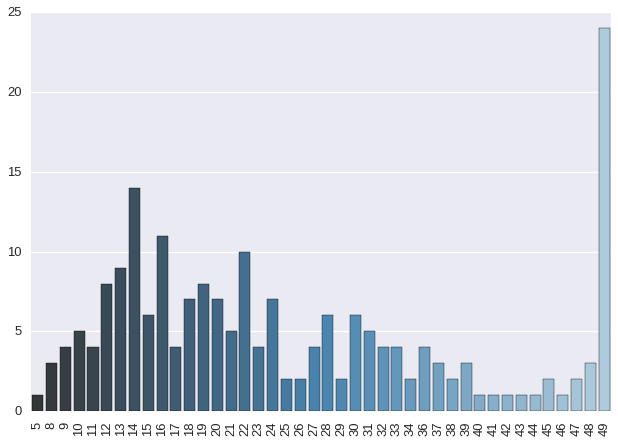

In [21]:
t = np.array([len(i.nonzero()[0]) for i in labels])
x = sorted(list(set(t)))
g = sns.barplot(y = [len(t[t[:]==i]) for i in x],
            x = x,
            ci=None,orient="v",palette="Blues_d")
g.set_xticklabels(x,rotation=90)
plt.show()

In [22]:
len(df)

149773

In [23]:
%%time
align = 100000
justify_right = False
ddd,_ = select_normalize_from_df({u'end': u'2015/01/01 17:45', u'start': u'2010/03/23 15:00'},
                                 df,align,justify_right=justify_right)
data_indicators = np.array([ddd])
print(data_indicators.shape)

(1, 100000, 10)
CPU times: user 228 ms, sys: 24 ms, total: 252 ms
Wall time: 250 ms


In [66]:
# !pip install pandas_profiling
# import pandas_profiling
# pandas_profiling.ProfileReport(pd.DataFrame(data=[len(i) for i in selected_data]))

# zip(selected_data[0][0],indicators)

### What does our data look like?

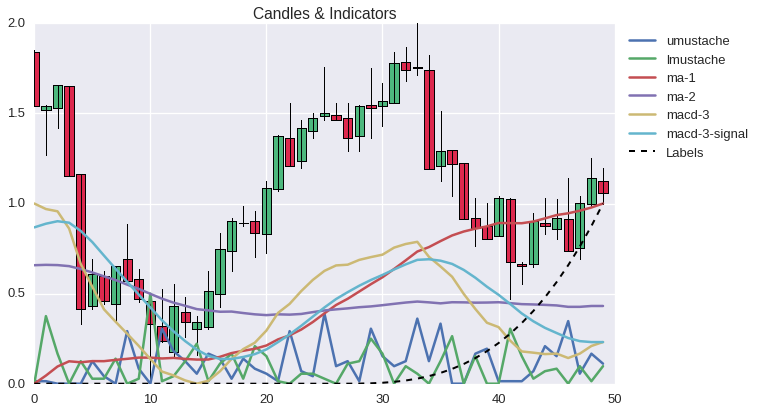

In [24]:
# random sample
plot_ohlc_ind(selected_data, r=-1, indicators=indicators, labels=labels)

# 1D Convolution
I adapt the kernel size, strides and padding, and input a 2D matrix with one of the dimension=1; simple.

In [40]:
#!pip install --upgrade chainer

In [25]:
import pickle
import numpy as np
# from PIL import Image
import os
# from StringIO import StringIO
import math
import pylab


import chainer
from chainer import computational_graph
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Variable
from chainer.utils import type_check
from chainer import function
from chainer import initializers

import chainer.functions as F
import chainer.links as L


import numpy

Compute output size, which is obtained with:  
$$n_{out}=((n_{in} + 2*n_{padding} - n_{filter}) / n_{stride} + 1) * n_{channel}$$

In [26]:
def get_output_size(*args):
    """ (in, [l_pad, l_k, l_ch, l_st], [l_pad, l_k, l_ch, l_st], ...)
    Example:
        (input_size,
         [layer_1_padding, layer_1_filter, layer_1_channel, layer_1_stride],
         [layer_2_padding, layer_2_filter, layer_2_channel, layer_2_stride],
         ...
         [layer_N_padding, layer_N_filter, layer_N_channel, layer_N_stride],
        )
        
    Computed as:
    $$n_{out}=((n_{in} + 2*n_{padding} - n_{filter}) / n_{stride} + 1) * n_{channel}$$
    """
    out = -1
    previous = 1
    for idx,i in enumerate(args):
        if idx==0:
            out=i
            continue
        out = ( (out/previous + 2*i[0] - i[1]) / i[3] + 1) * i[2]
        previous = i[2]
    return out

In [436]:
# params
input_size = selected_data.shape[1]
input_channels = selected_data.shape[2] #10
ch1,ch2,ch3,ch4 = 64,64,128,64
k1,k2,k3,k4 = 3,5,8,8
st1,st2,st3,st4 = 1,2,1,2
p1,p2,p3,p4 = 2,2,2,2

fullco_val = get_output_size(input_size, [p1,k1,ch1,st1], [p2,k2,ch2,st2], [p3,k3,ch3,st3])#, [p4,k4,ch4,st4])

class CNN_1D(chainer.Chain):
    def __init__(self):
        super(CNN_1D, self).__init__(
            c1_1 = L.Convolution2D(input_channels, ch1, (k1, 1), stride=(st1,1), pad=(p1,0)),
            bn1_1=L.BatchNormalization(ch1),
#             c1_2 = L.Convolution2D(ch1, ch1, (k1, 1), stride=(st1,1), pad=(0,0)),
#             bn1_2=L.BatchNormalization(ch1),
            
            c2_1 = L.Convolution2D(ch1, ch2, (k2, 1), stride=(st2,1), pad=(p2,0)),
            bn2_1=L.BatchNormalization(ch2),
#             c2_2 = L.Convolution2D(ch2, ch2, (k2, 1), stride=(st2,1), pad=(0,0)),
#             bn2_2=L.BatchNormalization(ch2),
            
            c3_1 = L.Convolution2D(ch2, ch3, (k3, 1), stride=(st3,1), pad=(p3,0)),
            bn3_1=L.BatchNormalization(ch3),
            
#             c4_1 = L.Convolution2D(ch3, ch4, (k4, 1), stride=(st4,1), pad=(p4,0)),
#             bn4_1=L.BatchNormalization(ch4),
            
#             c3 = L.Convolution2D(256, 512, (4, 1), stride=1, pad=0, wscale=1), #0.02*math.sqrt(4*4*256)),
            #
            # The problem with this fully connected layer is that it's
            # preventing the network to work on arbitrary sized inputs...
            # 
            # Max pooling used in a proper way could prevent this but
            # it's adding location invariance, we don't want that
            #
            l4 = L.Linear(fullco_val, 200), # maxpooling 768
            l5 = L.Linear(200, 1),
        )
        
    def __call__(self, x, train=False):
        h = F.relu(self.c1_1(x)) # BN finetune=True
#         h = F.relu(self.bn1_1(self.c1_1(x), test=not train)) # BN finetune=True
#         h = F.relu(self.bn1_2(self.c1_2(h), test=not train))
#         h = F.max_pooling_2d(h,(2,2),stride=2)
        h = F.dropout(h, ratio=0.5, train=train)
        
        h = F.relu(self.c2_1(h))
#         h = F.relu(self.bn2_1(self.c2_1(h), test=not train))
#         h = F.relu(self.bn2_2(self.c2_2(h), test=not train))
#         h = F.max_pooling_2d(h,(2,2),stride=2)
        h = F.dropout(h, ratio=0.5, train=train)
        
        h = F.relu(self.c3_1(h))
#         h = F.relu(self.bn3_1(self.c3_1(h), test=not train))
#         h = F.max_pooling_2d(h,(2,2),stride=2)
        h = F.dropout(h, ratio=0.5, train=train)
        
#         h = F.relu(self.bn4_1(self.c4_1(h), test=not train))
#         h = F.dropout(h, train=train)

        h = F.dropout(F.relu(self.l4(h)), ratio=0.5, train=train)
        h = F.tanh(self.l5(h)) # what's the exact benefit of tanh here?
# #         mp0 = F.MaxPooling2D(4)
        return h

In [437]:
print(fullco_val)

2944


Output size  
$$n_{out}=(n_{in} + 2*n_{padding} - n_{filter} + 1)$$
$$n_{out}=((n_{in} + 2*n_{padding} - n_{filter}) / n_{stride} + 1) * n_{channel}$$

In [318]:
cnn = CNN_1D()

# 
# Variable can make use of:  volatile=not train
# speedup?
# 

# va = Variable(np.array([real_data[0]]))
va = Variable(np.reshape(real_data[0],(1,10,real_data[0].shape[0],1))) # batch, channels, dim1, dim2

ret = cnn(va)
ret.data

array([[ nan]], dtype=float32)

In [1273]:
initializers.init_weight(cnn.c1_1.W.data, initializers.GlorotNormal(), scale=1.0)
initializers.init_weight(cnn.c2_1.W.data, initializers.GlorotNormal(), scale=1.0)
initializers.init_weight(cnn.c3_1.W.data, initializers.GlorotNormal(), scale=1.0)
initializers.init_weight(cnn.l4.W.data, initializers.HeNormal(), scale=1.0)
initializers.init_weight(cnn.l5.W.data, initializers.HeNormal(), scale=1.0)

# Our problem definition:
* One-class
* Unbalanced
* Semi-supervised

### Handling unbalanced dataset:

[stackexchange answer](http://stats.stackexchange.com/questions/193887/classification-with-a-neural-network-when-one-class-has-disproportionately-many) (strange, to try for simplicity)

>The algorithm trains the first learner, L1, one the original data set. The second learner, L2, is train on a set on which L1 has 50% chance to be correct (by sampling from the original distribution). The third learner, L3, is trained on the cases on which L1 and L2 disagree. As output, return the majority of the classifiers. See the paper to see why it improves the classification.

>Now for the application of the method of an imbalanced set. Assume the concept is binary and the majority of the samples are classified as true.

>Let L1 return always true. L2, is being trained were L1 has 50% to be right. Since L1 is just tre, L2 is being training on a balanced data set. L3 is being trained when L1 and L2 disagree, hence, when L2 predicts false. The ensemble predicts by majority, hence predicts false only when both L2 and L3 predict false.


## Experiments with 1D CNN
Create a simple binary classification dataset

In [29]:
# all_open = eod.db["GOOGL"]["Open"].values
all_open = data_indicators[0][:,:]#[0,-2,-1]]
# all_open2 = data_indicators2[0][:,:]#[0,-2,-1]]
# all_open = selected_data[0][:,0]
# len_samples = 100
# size_dataset = len(triangledescending.keys())*2

In [30]:
#selected_data = reshaped_data

In [31]:
selected_data.shape

(203, 50, 10)

In [32]:
augment_factor = 1
# size_dataset = 52 * 2 * augment_factor 
size_dataset = selected_data.shape[0] * augment_factor * 2 #selected_data.shape[0]*2 #10000
len_samples = selected_data.shape[1]

# fake_data = center(np.cumsum(np.random.randn(size_dataset/2, len_samples),axis=1).astype(np.float32)) #*2 - 1
# fake_data = np.array([
#         center(i) for i in np.cumsum(np.random.randn(size_dataset/2, len_samples),axis=1).astype(np.float32)
#     ])

fake_data = np.empty((size_dataset/2, len_samples, input_channels),dtype=np.float32)
for idxi,i in enumerate(fake_data):
    rand = np.random.randint(0,len(all_open)-(len_samples))

    c = copy.deepcopy(all_open[rand:rand+len_samples])
    c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
    c[:,[4,5]] = center_01(c[:,[4,5]])
    c[:,[6,7]] = center_01(c[:,[6,7]])
    c[:,[8,9]] = center_01(c[:,[8,9]])

    fake_data[idxi] = c

real_data = selected_data[:,:,:]#[0,-2,-1]]
real_data = np.repeat(real_data,augment_factor,axis=0)

# real_data = np.empty((size_dataset/2, len_samples, input_channels),dtype=np.float32)
# for idxi,i in enumerate(real_data):
#     rand = np.random.randint(0,len(all_open)-(len_samples))

#     c = copy.deepcopy(all_open2[rand:rand+len_samples])
#     c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
#     c[:,[4,5]] = center_01(c[:,[4,5]])
#     c[:,[6,7]] = center_01(c[:,[6,7]])
#     c[:,[8,9]] = center_01(c[:,[8,9]])

#     real_data[idxi] = c

In [33]:
fake_data.shape

(203, 50, 10)

In [34]:
real_data.shape

(203, 50, 10)

True


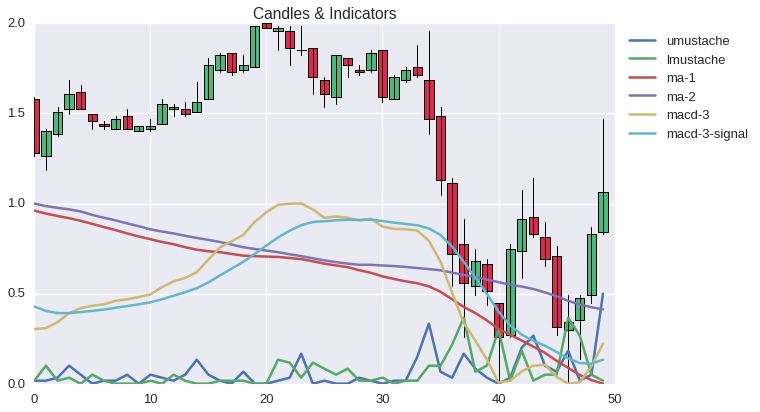

False


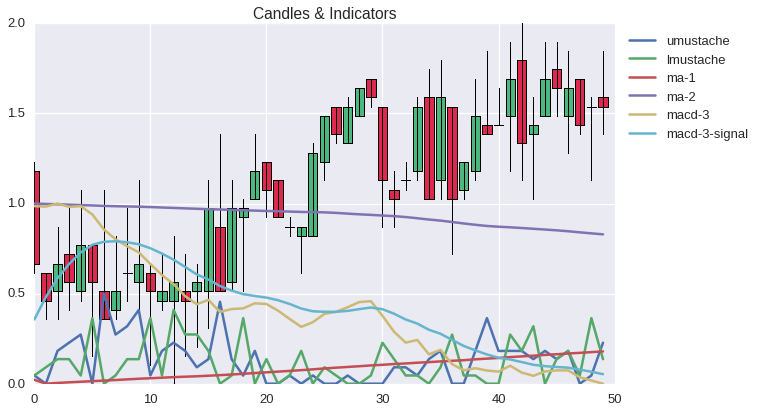

In [35]:
r = np.random.choice(range(len(real_data)))
print("True")
plot_ohlc_ind(real_data, r=r, indicators=indicators)
print("False")
plot_ohlc_ind(fake_data, r=r, indicators=indicators)

In [383]:
# data = np.array(zip(np.concatenate((real_data,fake_data)),
# #            np.array([[-1,1]]*len(fake_data) + [[1,-1]]*len(real_data)).astype(np.int32)
#            np.array( [[1]]*len(real_data) + [[-1]]*len(fake_data) ).astype(np.int32)
#           ))
data = np.concatenate((real_data,fake_data)).astype(np.float32)
all_labels = np.array( [[1]]*len(real_data) + [[-1]]*len(fake_data) ).astype(np.int32)
# all_labels = np.array( [[1,0]]*len(real_data) + [[0,1]]*len(fake_data) ).astype(np.int32)
print(data.shape)
data = np.swapaxes(data,1,2)
print(data.shape)
data = np.reshape(data, data.shape + (1,))
print(data.shape)
# data = np.array(zip(train_test,all_labels))
print(all_labels.shape)

(406, 50, 10)
(406, 10, 50)
(406, 10, 50, 1)
(406, 1)


In [384]:
l = int(len(data) * 0.9)
permut = np.random.permutation(len(data))
data = data[permut]
all_labels = all_labels[permut]
x_train , x_test = data[:l]   , data[l:]
y_train , y_test = all_labels[:l] , all_labels[l:]
print(len(x_train),len(x_test))
print(len(y_train),len(y_test))
print(np.sum(y_train+1)/2)

365 41
365 41
182


---
### Siamese Network

In [419]:
# params
input_size = selected_data.shape[1]
input_channels = selected_data.shape[2] #10
ch1,ch2,ch3,ch4 = 32,64,128,64
k1,k2,k3,k4 = 3,5,8,8
st1,st2,st3,st4 = 1,1,2,2
p1,p2,p3,p4 = 2,2,2,2

fullco_val2 = get_output_size(input_size, [p1,k1,ch1,st1], [p2,k2,ch2,st2], [p3,k3,ch3,st3])#, [p4,k4,ch4,st4])

class Siamese_CNN_1D(chainer.Chain):
    def __init__(self):
        super(Siamese_CNN_1D, self).__init__(
            c1_1 = L.Convolution2D(input_channels, ch1, (k1, 1), stride=(st1,1), pad=(p1,0)),
            bn1_1=L.BatchNormalization(ch1),
            
            c2_1 = L.Convolution2D(ch1, ch2, (k2, 1), stride=(st2,1), pad=(p2,0)),
            bn2_1=L.BatchNormalization(ch2),
            
            c3_1 = L.Convolution2D(ch2, ch3, (k3, 1), stride=(st3,1), pad=(p3,0)),
            bn3_1=L.BatchNormalization(ch3),

            #
            # The problem with this fully connected layer is that it's
            # preventing the network to work on arbitrary sized inputs...
            l4 = L.Linear(fullco_val2, 200), # maxpooling 768
            l5 = L.Linear(200, 2),
        )
        
    def __call__(self, x, train=False):
#         h0 = F.relu(self.bn1_1(self.c1_1(x0), test=not train)) # BN finetune=True
# #         h = F.max_pooling_2d(h,(2,2),stride=2)
#         h0 = F.dropout(h0, ratio=0.5, train=train)
#         h0 = F.relu(self.bn2_1(self.c2_1(h0), test=not train))
# #         h = F.max_pooling_2d(h,(2,2),stride=2)
#         h0 = F.dropout(h0, ratio=0.5, train=train)
#         h0 = F.relu(self.bn3_1(self.c3_1(h0), test=not train))
# #         h = F.max_pooling_2d(h,(2,2),stride=2)
#         h0 = F.dropout(h0, ratio=0.5, train=train)
#         ###
#         h1 = F.relu(self.bn1_1(self.c1_1(x1), test=not train)) # BN finetune=True
# #         h = F.max_pooling_2d(h,(2,2),stride=2)
#         h1 = F.dropout(h1, ratio=0.5, train=train)
#         h1 = F.relu(self.bn2_1(self.c2_1(h1), test=not train))
# #         h = F.max_pooling_2d(h,(2,2),stride=2)
#         h1 = F.dropout(h1, ratio=0.5, train=train)
#         h1 = F.relu(self.bn3_1(self.c3_1(h1), test=not train))
# #         h = F.max_pooling_2d(h,(2,2),stride=2)
#         h1 = F.dropout(h1, ratio=0.5, train=train)
          ###
#         h = F.concat((h0,h1))
#         h = F.dropout(F.relu(self.l4(h)), ratio=0.5, train=train)
        
        
        h = F.relu(self.bn1_1(self.c1_1(x), test=not train)) # BN finetune=True
#         h = F.max_pooling_2d(h,(2,2),stride=2)
        h = F.dropout(h, ratio=0.5, train=train)

        h = F.relu(self.bn2_1(self.c2_1(h), test=not train))
#         h = F.max_pooling_2d(h,(2,2),stride=2)
        h = F.dropout(h, ratio=0.5, train=train)
        
        h = F.relu(self.bn3_1(self.c3_1(h), test=not train))
#         h = F.max_pooling_2d(h,(2,2),stride=2)
        h = F.dropout(h, ratio=0.5, train=train)
        
        h = F.dropout(F.relu(self.l4(h)), ratio=0.5, train=train)
        h = F.tanh(self.l5(h)) # what's the exact benefit of tanh here?
        return h

In [409]:
input_size = selected_data.shape[1]
input_channels = selected_data.shape[2] #10
ch1,ch2,ch3,ch4 = 32,64,128,64
k1,k2,k3,k4 = 3,5,8,8
st1,st2,st3,st4 = 1,1,2,2
p1,p2,p3,p4 = 2,2,2,2

fullco_val3 = get_output_size(input_size, [p1,k1,ch1,st1], [p2,k2,ch2,st2])#, [p4,k4,ch4,st4])

class Simplest(chainer.Chain):
    def __init__(self):
        super(Simplest, self).__init__(
            c1_1 = L.Convolution2D(input_channels, ch1, (k1, 1), stride=(st1,1), pad=(p1,0)),
#             bn1_1=L.BatchNormalization(ch1),
            
            c2_1 = L.Convolution2D(ch1, ch2, (k2, 1), stride=(st2,1), pad=(p2,0)),
#             bn2_1=L.BatchNormalization(ch2),


            l4 = L.Linear(832, 500), # maxpooling 768
            l5 = L.Linear(500, 50),
            l6 = L.Linear(50, 10),
        )
        
    def __call__(self, x, train=False):
        h = self.c1_1(x) # BN finetune=True
        h = F.max_pooling_2d(h,(2,2),stride=2)
#         h = F.dropout(h, ratio=0.5, train=train)

        h = self.c2_1(h)
        h = F.max_pooling_2d(h,(2,2),stride=2)
#         h = F.dropout(h, ratio=0.5, train=train)
        
        
        h = F.relu(self.l4(h))
        h = self.l5(h) # what's the exact benefit of tanh here?
        h = F.sigmoid(self.l6(h))
        return h
fullco_val3

3328

In [428]:
class Siamse_Train(chainer.Chain):
    def __init__(self, predictor):
        super(Siamse_Train, self).__init__(predictor=predictor)
    def __call__(self, x0, x1, t, train=True):
        y0 = self.predictor(x0, train=train)
#         y1 = self.predictor(x1, train=train)

#         self.loss = F.contrastive(y0, y1, t)
#         self.loss = F.batch_l2_norm_squared()
#         self.loss = F.mean_squared_error(y1,t)
        
        self.loss = F.hinge(F.softmax(y0),t)
        return self.loss

In [432]:
# scnn = Simplest()
scnn = Siamese_CNN_1D()
t_scnn = Siamse_Train(scnn)

optimizer = optimizers.Adam()
optimizer.setup(t_cnn)

In [433]:
%%time
scnn.to_gpu(USE_GPU)
t_scnn.to_gpu(USE_GPU)

n_epoch = 200
batch_size = 400
N = x_train.shape[0]

ttt = 0
tt = 0

for epoch in range(n_epoch):
    scnn.zerograds()
    
#     _example = []
#     _label = []
    
    # Random permutations, permissive for N < batch_size
    perm = np.random.permutation(max(N,( batch_size / N + 1) * N)) % N
    np.random.shuffle(perm)
    perm = perm[:max(N,batch_size)]
    
    b = 0 if batch_size > N else np.random.randint(0,N - batch_size)

    _examples_0 = x_train[perm[b:b+batch_size]]
    _examples_1 = x_train[perm[b:b+batch_size]][::-1]
    _labels_0 = y_train[perm[b:b+batch_size]]
    _labels_1 = y_train[perm[b:b+batch_size]][::-1]
    
#     xp = cuda.cupy if args.gpu >= 0 else np
#     label = xp.array(y0_batch == y1_batch, dtype=np.int32)
#     _labels = np.array(_labels_0 == _labels_1, dtype=np.int32).ravel()
    _labels = _labels_0.ravel()
        
    examples_0 = Variable(_examples_0)
    examples_1 = Variable(_examples_1)
    labels = Variable(_labels)
    
    examples_0.to_gpu(USE_GPU)
    examples_1.to_gpu(USE_GPU)
    labels.to_gpu(USE_GPU)
    
    optimizer.update(t_scnn,examples_0,examples_1,labels)
    
    t = t_scnn.loss
    t.to_cpu()
    tt += t.data
    ttt += 1.
    pri = True
    if pri and (epoch==0 or epoch%(n_epoch/10)==0 or epoch==n_epoch-1):
        print(tt/ttt)
        ttt = 0
        tt = 0
#         lo, pr, re, cm     = eval_net(x_train,y_train,eval_on = 1, batch_size=400) # min(len(train)-1, 400)
#         lo_, pr_, re_, cm_ = eval_net(x_test,y_test,eval_on = 1, batch_size=400)
#         print("Epoch %s: (accuracy)   train %0.2f , test %0.2f    ||   (precison/recall)   train %0.2f %0.2f, test %0.2f %0.2f"
#               %(str(epoch).ljust(10),lo, lo_,pr,re,pr_,re_))

2.17967104912
2.16544704437
2.17788860798
2.17260043621
2.16818760633
2.1793510437
2.18238098621
2.17202013731
2.17653478384
2.18293162584
2.17819553927
CPU times: user 4.08 s, sys: 156 ms, total: 4.24 s
Wall time: 4.22 s


In [410]:
USE_GPU = 2

def eval_net(x,y,eval_on=10,batch_size=400):
    
    tp,fp,tn,fn = 0,0,0,0
    
    N = x.shape[0]
    
    # Random permutations, permissive for N < batch_size
    perm = np.random.permutation(max(N,( batch_size / N + 1) * N)) % N
    np.random.shuffle(perm)
    perm = perm[:max(N,batch_size)]
    
    b = 0 if batch_size > N else np.random.randint(0,N - batch_size)

    _examples = x[perm[b:b+batch_size]]
    _labels = y[perm[b:b+batch_size]]
        
    examples = Variable(_examples)
#     label = Variable(_label.astype(np.float32))
    examples.to_gpu(USE_GPU)
#     label.to_gpu(USE_GPU)
    
#     optimizer.update(t_cnn,example,label)

    pred = cnn( examples , train=False)
    pred.to_cpu()

    for idxi,i in enumerate(_labels):
        if np.sign(pred.data[idxi,0]) > 0:
            if np.sign(_labels[idxi])==np.sign(pred.data[idxi,0]):
                # true positive
                tp += 1
            else:
                # false positive
                fp += 1
        else:
            if np.sign(_labels[idxi])==np.sign(pred.data[idxi,0]):
                # true negative
                tn += 1
            else:
                # false negative
                fn += 1
    eval_on = float(batch_size)
    mean_loss = (tp+tn) / eval_on
#     print("Tp %.03f, Fp %.03f\nTn %.03f, Fn %.03f"%(tp/eval_on,fp/eval_on,fn/eval_on,tn/eval_on))
#     print("Precision %.03f, Recall %.03f"%(0 if tp+fp==0 else tp/float(tp+fp), tp/float(tp+fn)))
    precision, recall = 0 if tp+fp==0 else tp/float(tp+fp), 0 if tp+fn==0 else tp/float(tp+fn)
    confusion_matrix  = [tp/eval_on,fp/eval_on,fn/eval_on,tn/eval_on]
    return mean_loss, precision, recall, confusion_matrix

In [438]:
cnn = CNN_1D()
t_cnn = Train(cnn)

optimizer = optimizers.Adam()
optimizer.setup(t_cnn)

In [441]:
%%time
cnn.to_gpu(USE_GPU)
t_cnn.to_gpu(USE_GPU)

n_epoch = 50
batch_size = 400
N = x_train.shape[0]

for epoch in range(n_epoch):
    cnn.zerograds()
    
#     _example = []
#     _label = []
    
    # Random permutations, permissive for N < batch_size
    perm = np.random.permutation(max(N,( batch_size / N + 1) * N)) % N
    np.random.shuffle(perm)
    perm = perm[:max(N,batch_size)]
    
    b = 0 if batch_size > N else np.random.randint(0,N - batch_size)
#     for b in range(batch_size):
#         r_index = np.random.randint(len(train))
    _examples = x_train[perm[b:b+batch_size]]
    _labels = y_train[perm[b:b+batch_size]]
#     _examples.append(np.reshape(_example,(_example.shape[1],_example.shape[0],1)))
#     _labels.append(np.array(_label).astype(np.float32))
        # np.reshape(_example,(1,1,_example.shape[0],1))
        
    examples = Variable(_examples)
    labels = Variable(_labels.astype(np.float32)) #.astype(np.float32)
# #     t_cnn( Variable(ppp),Variable(np.reshape(label,(1,1)) ))
    examples.to_gpu(USE_GPU)
    labels.to_gpu(USE_GPU)
    
    optimizer.update(t_cnn,examples,labels)
    
    pri = True
    if pri and (epoch==0 or epoch%(n_epoch/10)==0 or epoch==n_epoch-1):
        lo, pr, re, cm     = eval_net(x_train,y_train,eval_on = 1, batch_size=400) # min(len(train)-1, 400)
        lo_, pr_, re_, cm_ = eval_net(x_test,y_test,eval_on = 1, batch_size=400)
        print("Epoch %s: (accuracy)   train %0.2f , test %0.2f    ||   (precison/recall)   train %0.2f %0.2f, test %0.2f %0.2f"
              %(str(epoch).ljust(10),lo, lo_,pr,re,pr_,re_))

Epoch 0         : (accuracy)   train 0.88 , test 0.83    ||   (precison/recall)   train 0.87 0.90, test 0.82 0.85
Epoch 5         : (accuracy)   train 0.90 , test 0.79    ||   (precison/recall)   train 0.87 0.94, test 0.76 0.86
Epoch 10        : (accuracy)   train 0.89 , test 0.81    ||   (precison/recall)   train 0.90 0.86, test 0.84 0.77
Epoch 15        : (accuracy)   train 0.92 , test 0.85    ||   (precison/recall)   train 0.87 0.97, test 0.83 0.91
Epoch 20        : (accuracy)   train 0.89 , test 0.82    ||   (precison/recall)   train 0.90 0.89, test 0.85 0.80
Epoch 25        : (accuracy)   train 0.90 , test 0.82    ||   (precison/recall)   train 0.87 0.94, test 0.82 0.86
Epoch 30        : (accuracy)   train 0.90 , test 0.81    ||   (precison/recall)   train 0.88 0.92, test 0.82 0.81
Epoch 35        : (accuracy)   train 0.93 , test 0.78    ||   (precison/recall)   train 0.91 0.96, test 0.80 0.76
Epoch 40        : (accuracy)   train 0.92 , test 0.78    ||   (precison/recall)   train 

In [205]:
for i in np.shape(_example[2].astype(np.float32))

(10, 50, 1)

In [217]:
_example[0][1][0][0]

0.18870895

In [210]:
np.array(_example,dtype=np.float32)

ValueError: setting an array element with a sequence.

In [197]:
type(example.data)

numpy.ndarray

In [104]:
batch[0][0].shape

(50, 10)

In [44]:
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t, train=True):
        y = self.predictor(x, train=train)
#         self.loss = F.sigmoid_cross_entropy(y, t) # softmax
        self.loss = F.mean_squared_error(y, t) # softmax
        return self.loss

In [45]:
def plot_confusion_matrix(cm,title="Confusion Matrix"):
    # cm = tp/eval_on,fp/eval_on,fn/eval_on,tn/eval_on
    sns.heatmap(np.reshape(cm,(2,2)),annot=True,
                xticklabels=["True","False"],yticklabels=["Positive","Negative"],
                cbar=False,
                annot_kws={"size":"x-large","weight":"bold"}
               )
    plt.title(title)
    plt.show()

#### GPU training

In [45]:
USE_GPU = 2

def eval_loss(data,eval_on=10):
    sum_loss = 0
    for i in range(0, eval_on):
        r_index = np.random.randint(len(data))
        _example,_label = data[r_index][0], data[r_index][1]
        example = Variable(np.reshape(_example,(1,1,_example.shape[0],1)), volatile=True)
        label = Variable(np.array([_label]).astype(np.float32), volatile=True) #.astype(np.float32)
        loss = t_cnn( example,label )

        sum_loss += loss.data
    mean_loss = sum_loss / eval_on
    return mean_loss

def eval_accuracy(data,eval_on=10,batch_size=50):
    train = False
    sum_loss = 0.
    for i in range(0, eval_on):        
        _examples = []
        _labels = []
        for b in range(batch_size):
            r_index = np.random.randint(len(data))
            _example,_label = data[r_index][0], data[r_index][1]
            _examples.append(np.reshape(_example,(_example.shape[1],_example.shape[0],1)))
            _labels.append(_label)
            
        # xp = chainer.cuda.get_array_module(x.data)
        example = Variable(np.array(_examples), volatile=True)
        example.to_gpu(USE_GPU)
        
        pred = cnn( example , train=train)
        pred.to_cpu()
        
        for idxi,i in enumerate(_labels):
            sum_loss += 1 if np.sign(_labels[idxi])==np.sign(pred.data[idxi,0]) else 0
    mean_loss = sum_loss / (eval_on*batch_size)
    return mean_loss

def eval_accuracy_half_stochastic(data,eval_on=10,batch_size=None):
    tp,fp,tn,fn = 0,0,0,0
    _examples = []
    _labels = []
#     eval_on = min(len(data),eval_on)
    r_index = np.random.randint(len(data)-eval_on)
    
    # duh...
    for b in range(r_index, r_index+eval_on):
#         r_index = np.random.randint(len(data))
        _example,_label = data[b][0], data[b][1]
        _examples.append(np.reshape(_example,(_example.shape[1],_example.shape[0],1)))
        _labels.append(_label)

    example = Variable(np.array(_examples), volatile=True)
    example.to_gpu(USE_GPU)

    pred = cnn( example , train=False)
    pred.to_cpu()

    for idxi,i in enumerate(_labels):
        if np.sign(pred.data[idxi,0]) > 0:
            if np.sign(_labels[idxi])==np.sign(pred.data[idxi,0]):
                # true positive
                tp += 1
            else:
                # false positive
                fp += 1
        else:
            if np.sign(_labels[idxi])==np.sign(pred.data[idxi,0]):
                # true negative
                tn += 1
            else:
                # false negative
                fn += 1
    eval_on = float(eval_on)
    mean_loss = (tp+tn) / eval_on
#     print("Tp %.03f, Fp %.03f\nTn %.03f, Fn %.03f"%(tp/eval_on,fp/eval_on,fn/eval_on,tn/eval_on))
#     print("Precision %.03f, Recall %.03f"%(0 if tp+fp==0 else tp/float(tp+fp), tp/float(tp+fn)))
    precision, recall = 0 if tp+fp==0 else tp/float(tp+fp), 0 if tp+fn==0 else tp/float(tp+fn)
    confusion_matrix  = [tp/eval_on,fp/eval_on,fn/eval_on,tn/eval_on]
    return mean_loss, precision, recall, confusion_matrix

In [46]:
# initializers.init_weight(cnn.c1_1.W.data, initializers.GlorotNormal(), scale=1.0)
# initializers.init_weight(cnn.c2_1.W.data, initializers.GlorotNormal(), scale=1.0)
# initializers.init_weight(cnn.c3_1.W.data, initializers.GlorotNormal(), scale=1.0)
# initializers.init_weight(cnn.l4.W.data, initializers.HeNormal(), scale=1.0)
# initializers.init_weight(cnn.l5.W.data, initializers.HeNormal(), scale=1.0)

# initializers.init_weight(cnn.c1_1.W.data, initializers.GlorotUniform(), scale=1.0)
# initializers.init_weight(cnn.c2_1.W.data, initializers.GlorotUniform(), scale=1.0)
# initializers.init_weight(cnn.c3_1.W.data, initializers.GlorotUniform(), scale=1.0)
# initializers.init_weight(cnn.l4.W.data, initializers.HeUniform(), scale=1.0)
# initializers.init_weight(cnn.l5.W.data, initializers.HeUniform(), scale=1.0)

# because ReLU
# cnn.c1_1.W.data += 0.05
# cnn.c2_1.W.data += 0.05
# cnn.c3_1.W.data += 0.05
# cnn.l4.W.data   += 0.05

In [298]:
cnn = CNN_1D()
t_cnn = Train(cnn)

optimizer = optimizers.Adam()
optimizer.setup(t_cnn)

In [122]:
%%time
cnn.to_gpu(USE_GPU)
t_cnn.to_gpu(USE_GPU)

n_epoch = 10
batch_size = 11

for epoch in range(n_epoch):
    cnn.zerograds()
    
    _examples = []
    _labels = []
    for b in range(batch_size):
        r_index = np.random.randint(len(train))
        _example,_label = train[r_index][0], train[r_index][1]
        _examples.append(np.reshape(_example,(_example.shape[1],_example.shape[0],1)))
        _labels.append(np.array(_label).astype(np.float32))
        # np.reshape(_example,(1,1,_example.shape[0],1))
        
    example = Variable(np.array(_examples))
    label = Variable(np.array(_labels)) #.astype(np.float32)
#     t_cnn( Variable(ppp),Variable(np.reshape(label,(1,1)) ))
    example.to_gpu(USE_GPU)
    label.to_gpu(USE_GPU)
    
    optimizer.update(t_cnn,example,label)
    
    pri = True
    if pri and (epoch==0 or epoch%(n_epoch/10)==0 or epoch==n_epoch-1):
        lo, pr, re, cm     = eval_accuracy_half_stochastic(train,eval_on = min(len(train)-1, 400))#len(train)-1)
        lo_, pr_, re_, cm_ = eval_accuracy_half_stochastic(test, eval_on = min(len(test)-1, 400))#len(test)-1)
        print("Epoch %s: (accuracy)   train %0.2f , test %0.2f    ||   (precison/recall)   train %0.2f %0.2f, test %0.2f %0.2f"
              %(str(epoch).ljust(10),lo, lo_,pr,re,pr_,re_))

Epoch 0         : (accuracy)   train 0.96 , test 0.75    ||   (precison/recall)   train 0.93 1.00, test 0.72 0.80
Epoch 1         : (accuracy)   train 0.96 , test 0.74    ||   (precison/recall)   train 0.93 1.00, test 0.70 0.83
Epoch 2         : (accuracy)   train 0.96 , test 0.75    ||   (precison/recall)   train 0.93 1.00, test 0.70 0.87
Epoch 3         : (accuracy)   train 0.94 , test 0.73    ||   (precison/recall)   train 0.89 1.00, test 0.67 0.90
Epoch 4         : (accuracy)   train 0.91 , test 0.72    ||   (precison/recall)   train 0.85 1.00, test 0.66 0.91
Epoch 5         : (accuracy)   train 0.91 , test 0.71    ||   (precison/recall)   train 0.85 1.00, test 0.65 0.93
Epoch 6         : (accuracy)   train 0.91 , test 0.73    ||   (precison/recall)   train 0.85 1.00, test 0.67 0.92
Epoch 7         : (accuracy)   train 0.94 , test 0.75    ||   (precison/recall)   train 0.89 1.00, test 0.69 0.89
Epoch 8         : (accuracy)   train 0.95 , test 0.75    ||   (precison/recall)   train 

In [123]:
example.data.shape

(11, 10, 50, 1)

In [957]:
# USDJPY vs EURUSD
eval_accuracy(train,eval_on=50,batch_size=200),eval_accuracy(test,eval_on=50,batch_size=200)

(1.0, 0.7458)

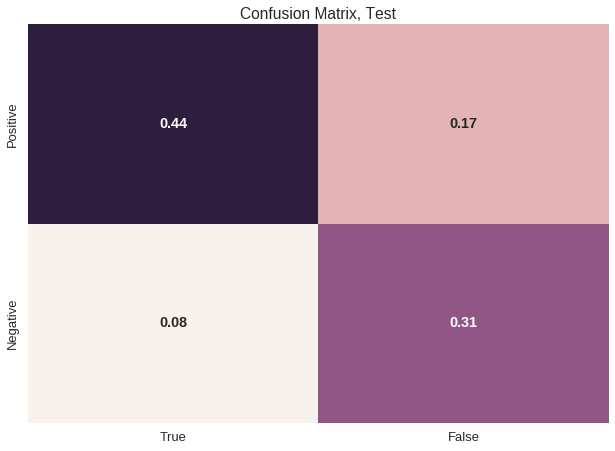

In [958]:
# plot_confusion_matrix(cm,title="Confusion Matrix, Train")
plot_confusion_matrix(cm_,title="Confusion Matrix, Test")

In [58]:
cnn.to_cpu()
t_cnn.to_cpu()

In [960]:
def plot_ohlc_confidence(sh,r=-1,indicators=indicators,mask_size=10):
    r = r if r!=-1 else np.random.randint(len(sh))
    
#     r_index = np.random.randint(len(sh))
    _example,_label = sh[r][0], sh[r][1]
    example = Variable(np.reshape(_example,(1,_example.shape[1],_example.shape[0],1)))
    pred = cnn( example ).data
    
    impact = []
    m2 = mask_size / 2

    for i in range(m2,len(_example),mask_size):
        _mod = copy.deepcopy(_example)
        _mod[i-m2:i+m2] = 0.5 #np.random.rand(*_mod[i-m2:i+m2].shape)
        example = Variable(np.reshape(_mod,(1,_mod.shape[1],_mod.shape[0],1)))
        _pred = cnn( example ).data
        impact.append(pred - _pred[0,0])
    y = np.repeat(impact,mask_size)
        
    c = copy.deepcopy(_example)
    c[:,[0,1,2,3]] = c[:,[0,1,2,3]] *2
    c[:,[4,5]] = c[:,[4,5]] /2
    c[:,[6,7]] = c[:,[6,7]]
    c[:,[8,9]] = c[:,[8,9]]
        
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)

    candlestick2_ohlc(ax, c[:,0], c[:,1], c[:,2], c[:,3], width=0.8,
                      colorup='mediumseagreen', colordown='crimson', alpha=0.9)

    for i in range(4,len(c[0])):
        plt.plot(c[:,i],label=indicators[i])
    plt.plot(y,color="r",alpha=0.2,zorder=1)
    plt.fill_between(range(len(_example)),y,[0]*len(_example),color="r",alpha=0.15,zorder=1,label="fuzzy interest")
    plt.title("Candles & Indicators (%s)"%r)
    plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)
    
    ax.set_xlim(xmin=0)

    plt.show()
    
    print(_label, pred[0])
    print("Ok" if np.sign(_label[0])==np.sign(pred[0,0]) else "WRONG prediction")

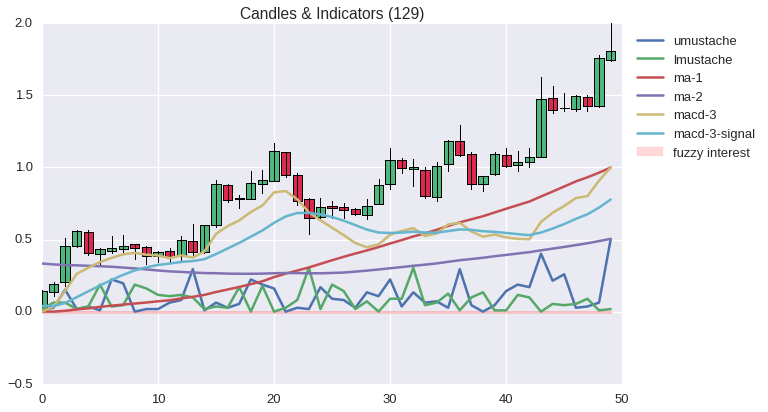

[-1] [-1.]
Ok


In [968]:
# plot_ohlc_confidence(test,r=-1,mask_size=2)
plot_ohlc_confidence(test,r=-1,mask_size=2)

In [969]:
cnn.to_gpu(USE_GPU)
t_cnn.to_gpu(USE_GPU)

In [970]:
def output(arr):
#     r = r if r!=-1 else np.random.randint(len(sh))
    
#     r_index = np.random.randint(len(sh))

#     a = np.transpose(np.array(arr).astype(np.float32),(0,2,1))
#     a = np.reshape(a,(a.shape+(1,)))
    ###     np.reshape(_example,(_example.shape[1],_example.shape[0],1))
    a = np.array(arr).astype(np.float32)
    a = np.reshape(a,(a.shape[0], a.shape[2], a.shape[1], 1))
    example = Variable(a, volatile=True)
    example.to_gpu(USE_GPU)

    pred = cnn( example , train=False)
#     print(pred.data[0][0])


#     _example = sh
#     example = Variable(np.reshape(_example,(1,_example.shape[1],_example.shape[0],1)))
#     pred = cnn( example ).data
    pred.to_cpu()
    return pred.data

In [971]:
# def center_01(x):
#     c = (x - x.min())/(x.max() - x.min())
#     return np.array([i for i in c]).astype(np.float32)

# def pandas_normalize(df):
    
# #     t,y = process_range(r, df, align, justify_right=justify_right)
    
#     c = copy.deepcopy(df.values)
# #     print(type(c))
#     c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
#     c[:,[4,5]] = center_01(c[:,[4,5]])
#     c[:,[6,7]] = center_01(c[:,[6,7]])
#     c[:,[8,9]] = center_01(c[:,[8,9]])

#     return c

In [972]:
len(to_process)

149722

In [973]:
len(train)

81

In [974]:
%%time

to_process = [] #np.zeros((ran,100,10))

# first_end = "2014/01/02 01:50" #dataset[0]
# last_end = "2014/12/30 11:10" #dataset[-1]
first_end = df.index[0].strftime("%Y-%m-%d %H:%M:%S")
last_end = df.index[-1].strftime("%Y-%m-%d %H:%M:%S")
idx_deb = df.index.get_loc(first_end)
idx_end = df.index.get_loc(last_end)
# ran = len(df)
win = input_size

for i in range(idx_deb + win, idx_end):
#     print(i)
    c = normalize_array(df[i-win:i])
    to_process.append(c)
# print(i)

CPU times: user 1min 1s, sys: 160 ms, total: 1min 2s
Wall time: 1min 2s


In [975]:
np.shape(to_process)

(149722, 50, 10)

In [976]:
%%time
step=400
over=len(to_process)
res = np.zeros(over)
for i in range(0,over,step):
    res[i:i+step] = output(to_process[i:i+step])[:,0]

CPU times: user 2.11 s, sys: 128 ms, total: 2.24 s
Wall time: 2.23 s


In [977]:
# dff = copy.deepcopy(df[idx_deb:idx_end-win])
dff = copy.deepcopy(df)
dff["y"] = np.zeros(len(dff))
for i in dataset:
    dff["y"][i["start"]:i["end"]] = 1

In [990]:
mod_res = np.where(res >= 0.,res,np.zeros(len(res)))

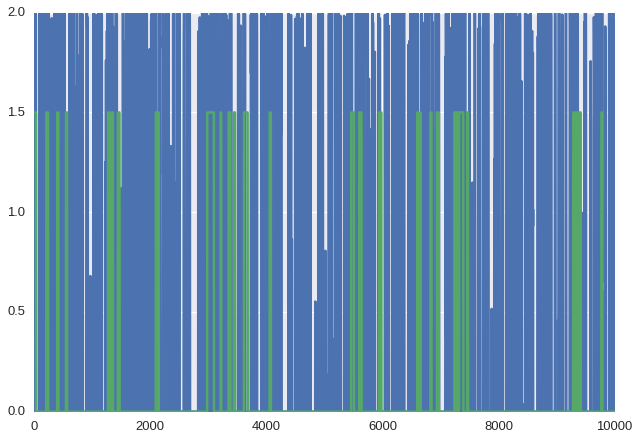

In [991]:
a = 20000
b = a + 10000
# _plot_ohlc_ind([pandas_normalize(dff[a:b])])
plt.plot(mod_res[a:b] * 2)
plt.plot(dff["y"][a:b].values * 1.5)
# plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)
plt.show()

In [992]:
len(res)

149722

9147


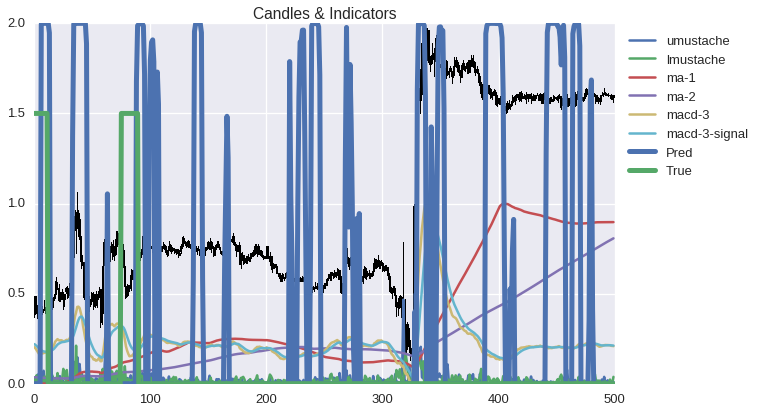

In [1007]:
a = np.random.randint(100,50000)
b = a + 500
print(a)
_plot_ohlc_ind([pandas_normalize(dff[a:b])])
plt.plot(mod_res[a:b]*2, label="Pred",linewidth=5)
plt.plot(dff["y"][a:b].values * 1.5,label="True",linewidth=5)
plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)
plt.show()

In [799]:
a
# 15815, 43631, 48304, 75714

75714

In [114]:
def _plot_ohlc_ind(selected_data,r=-1,indicators=indicators,labels=None):
    r = r if r!=-1 else np.random.choice(len(selected_data))
    c = copy.deepcopy(selected_data[r])
    c[:,[0,1,2,3]] = c[:,[0,1,2,3]] *2
    c[:,[4,5]] = c[:,[4,5]] /2
    c[:,[6,7]] = c[:,[6,7]]
    c[:,[8,9]] = c[:,[8,9]]

    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)


    candlestick2_ohlc(ax, c[:,0], c[:,1], c[:,2], c[:,3], width=0.8,
                      colorup='mediumseagreen', colordown='crimson', alpha=0.9)

    for i in range(4,min(len(c[0]),10)):
        plt.plot(c[:,i],label=indicators[i])
    if not (labels is None): plt.plot(labels[r],'k--',label="Labels",linewidth=2)
    plt.title("Candles & Indicators")
#     plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)

    ax.set_xlim(xmin=0)

#     plt.show()

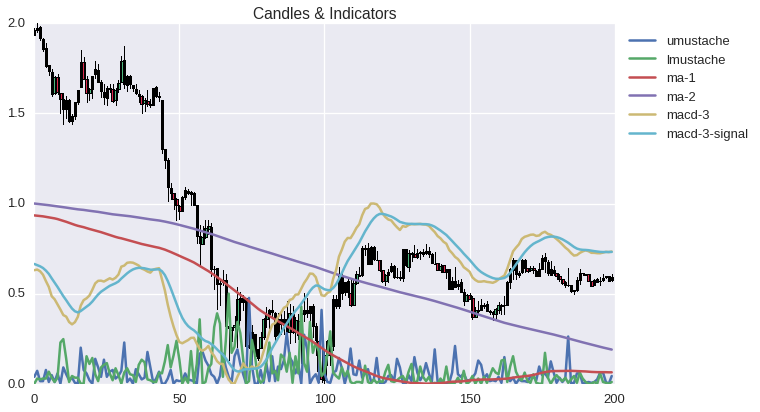

In [688]:
plot_ohlc_ind([pandas_normalize(df[2200:2400])])

In [569]:
last_end = "2014/12/30 11:10" #dataset[-1]
df.index.get_loc(last_end)

75945

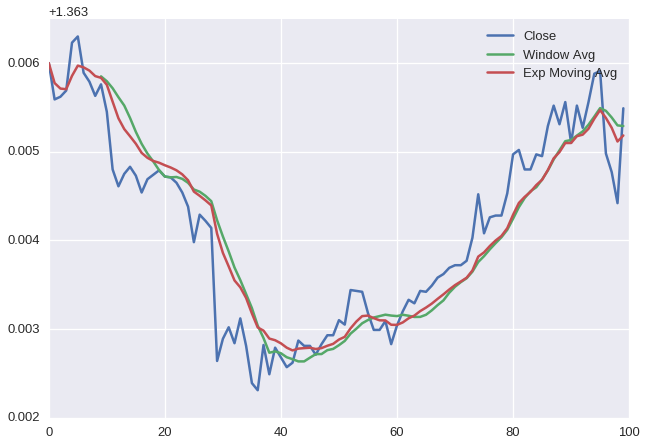

In [103]:
# Example pandas functions

plt.plot(df[0:100]["Close"].values,
        label="Close")
plt.plot(df[0:100]["Close"].rolling(window=10, min_periods=None, center=False).apply(lambda x: x.mean()).values,
        label="Window Avg")
plt.plot(df[0:100]["Close"].ewm(com=None, span=10, halflife=None, alpha=None,
       min_periods=0, freq=None, adjust=True, ignore_na=False, axis=0).mean().values,
        label="Exp Moving Avg")
# plt.plot(df[0:100]["Close"].expanding(min_periods=1, center=False).mean().values)
plt.legend()
plt.show()

In [306]:
def center_01(x):
    c = (x - x.min())/(x.max() - x.min())
    return np.array([i for i in c]).astype(np.float32)

def pandas_normalize(df, align=100):
    
#     t,y = process_range(r, df, align, justify_right=justify_right)

    c = t.values
    c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
    c[:,[4,5]] = center_01(c[:,[4,5]])
    c[:,[6,7]] = center_01(c[:,[6,7]])
    c[:,[8,9]] = center_01(c[:,[8,9]])

    return c

# def pandas_normalize(df, align=100):
    
# #     t,y = process_range(r, df, align, justify_right=justify_right)
# #     print()
# #     c = df
# #     c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
# #     c[:,[4,5]] = center_01(c[:,[4,5]])
# #     c[:,[6,7]] = center_01(c[:,[6,7]])
# #     c[:,[8,9]] = center_01(c[:,[8,9]])
# #     print(type(df))
#     return df.mean()

#     return c

In [281]:
ttt = df[0:100]

In [302]:
ttt.mean()

Open             1.367147
High             1.367326
Low              1.366972
Close            1.367148
umustache        0.000073
lmustache        0.000071
ma-1             1.368087
ma-2             1.372117
macd-3          -0.000062
macd-3-signal   -0.000105
dtype: float64

In [289]:
ttt.iloc[:,[3,4]]

Close  umustache
Date                                   
2013-12-19 00:00:00  1.36900    0.00003
2013-12-19 00:05:00  1.36859    0.00001
2013-12-19 00:10:00  1.36862    0.00020
2013-12-19 00:15:00  1.36869    0.00032
2013-12-19 00:20:00  1.36923    0.00001
2013-12-19 00:25:00  1.36930    0.00019
2013-12-19 00:30:00  1.36889    0.00000
2013-12-19 00:35:00  1.36879    0.00012
2013-12-19 00:40:00  1.36863    0.00012
2013-12-19 00:45:00  1.36876    0.00018
2013-12-19 00:50:00  1.36845    0.00000
2013-12-19 00:55:00  1.36780    0.00020
2013-12-19 01:00:00  1.36761    0.00001
2013-12-19 01:05:00  1.36775    0.00004
2013-12-19 01:10:00  1.36783    0.00003
2013-12-19 01:15:00  1.36773    0.00011
2013-12-19 01:20:00  1.36754    0.00000
2013-12-19 01:25:00  1.36769    0.00018
2013-12-19 01:30:00  1.36774    0.00000
2013-12-19 01:35:00  1.36779    0.00002
2013-12-19 01:40:00  1.36772    0.00003
2013-12-19 01:45:00  1.36771    0.00009
2013-12-19 01:50:00  1.36765    0.00006
2013-12-19 01:55:00  1.36754    0.00000
2013-12-19 02:00:00  1.36738    0.00016
2013-12-19 02:05:00  1.36698    0.00000
2013-12-19 02:10:00  1.36729    0.00000
2013-12-19 02:15:00  1.36722    0.00025
2013-12-19 02:20:00  1.36714    0.00011
2013-12-19 02:25:00  1.36564    0.00007
...                      ...        ...
2013-12-19 05:50:00  1.36672    0.00001
2013-12-19 05:55:00  1.36672    0.00011
2013-12-19 06:00:00  1.36677    0.00002
2013-12-19 06:05:00  1.36703    0.00000
2013-12-19 06:10:00  1.36752    0.00003
2013-12-19 06:15:00  1.36708    0.00003
2013-12-19 06:20:00  1.36726    0.00008
2013-12-19 06:25:00  1.36728    0.00007
2013-12-19 06:30:00  1.36728    0.00005
2013-12-19 06:35:00  1.36753    0.00005
2013-12-19 06:40:00  1.36797    0.00003
2013-12-19 06:45:00  1.36802    0.00012
2013-12-19 06:50:00  1.36780    0.00012
2013-12-19 06:55:00  1.36780    0.00004
2013-12-19 07:00:00  1.36797    0.00002
2013-12-19 07:05:00  1.36795    0.00006
2013-12-19 07:10:00  1.36829    0.00003
2013-12-19 07:15:00  1.36852    0.00029
2013-12-19 07:20:00  1.36831    0.00015
2013-12-19 07:25:00  1.36856    0.00007
2013-12-19 07:30:00  1.36810    0.00007
2013-12-19 07:35:00  1.36852    0.00022
2013-12-19 07:40:00  1.36827    0.00017
2013-12-19 07:45:00  1.36856    0.00001
2013-12-19 07:50:00  1.36888    0.00031
2013-12-19 07:55:00  1.36891    0.00010
2013-12-19 08:00:00  1.36798    0.00000
2013-12-19 08:05:00  1.36777    0.00012
2013-12-19 08:10:00  1.36742    0.00007
2013-12-19 08:15:00  1.36849    0.00014

[100 rows x 2 columns]

In [307]:
df[0:11].rolling(window=10, min_periods=None, center=False).apply(pandas_normalize)

Open      High       Low     Close  umustache  \
Date                                                                     
2013-12-19 00:00:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:05:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:10:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:15:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:20:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:25:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:30:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:35:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:40:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:45:00  1.368807  1.369074  1.368635  1.368850   0.000118   
2013-12-19 00:50:00  1.368852  1.369050  1.368627  1.368795   0.000115   

                     lmustache      ma-1      ma-2    macd-3  macd-3-signal  
Date                                                                         
2013-12-19 00:00:00        NaN       NaN       NaN       NaN            NaN  
2013-12-19 00:05:00        NaN       NaN       NaN       NaN            NaN  
2013-12-19 00:10:00        NaN       NaN       NaN       NaN            NaN  
2013-12-19 00:15:00        NaN       NaN       NaN       NaN            NaN  
2013-12-19 00:20:00        NaN       NaN       NaN       NaN            NaN  
2013-12-19 00:25:00        NaN       NaN       NaN       NaN            NaN  
2013-12-19 00:30:00        NaN       NaN       NaN       NaN            NaN  
2013-12-19 00:35:00        NaN       NaN       NaN       NaN            NaN  
2013-12-19 00:40:00        NaN       NaN       NaN       NaN            NaN  
2013-12-19 00:45:00   0.000066  1.371414  1.374104 -0.000058      -0.000316  
2013-12-19 00:50:00   0.000085  1.371320  1.374062 -0.000021      -0.000257

In [225]:
df[:100].rolling(center=False,window=10).mean()

Open      High       Low     Close  umustache  \
Date                                                                     
2013-12-19 00:00:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:05:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:10:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:15:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:20:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:25:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:30:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:35:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:40:00       NaN       NaN       NaN       NaN        NaN   
2013-12-19 00:45:00  1.368807  1.369074  1.368635  1.368850   0.000118   
2013-12-19 00:50:00  1.368852  1.369050  1.368627  1.368795   0.000115   
2013-12-19 00:55:00  1.368799  1.369016  1.368560  1.368716   0.000134   
2013-12-19 01:00:00  1.368715  1.368908  1.368439  1.368615   0.000115   
2013-12-19 01:05:00  1.368611  1.368786  1.368339  1.368521   0.000087   
2013-12-19 01:10:00  1.368515  1.368648  1.368239  1.368381   0.000089   
2013-12-19 01:15:00  1.368378  1.368492  1.368104  1.368224   0.000081   
2013-12-19 01:20:00  1.368221  1.368335  1.367973  1.368089   0.000081   
2013-12-19 01:25:00  1.368086  1.368220  1.367849  1.367979   0.000087   
2013-12-19 01:30:00  1.367978  1.368104  1.367748  1.367890   0.000075   
2013-12-19 01:35:00  1.367886  1.367991  1.367655  1.367793   0.000059   
2013-12-19 01:40:00  1.367785  1.367893  1.367606  1.367720   0.000062   
2013-12-19 01:45:00  1.367709  1.367807  1.367598  1.367711   0.000051   
2013-12-19 01:50:00  1.367705  1.367808  1.367636  1.367715   0.000056   
2013-12-19 01:55:00  1.367707  1.367793  1.367606  1.367694   0.000052   
2013-12-19 02:00:00  1.367686  1.367776  1.367575  1.367649   0.000065   
2013-12-19 02:05:00  1.367643  1.367722  1.367489  1.367574   0.000054   
2013-12-19 02:10:00  1.367571  1.367679  1.367438  1.367549   0.000054   
2013-12-19 02:15:00  1.367543  1.367644  1.367398  1.367502   0.000061   
2013-12-19 02:20:00  1.367496  1.367604  1.367350  1.367442   0.000072   
2013-12-19 02:25:00  1.367438  1.367545  1.367137  1.367227   0.000077   
...                       ...       ...       ...       ...        ...   
2013-12-19 05:50:00  1.366415  1.366538  1.366335  1.366477   0.000053   
2013-12-19 05:55:00  1.366485  1.366596  1.366382  1.366529   0.000058   
2013-12-19 06:00:00  1.366539  1.366627  1.366416  1.366573   0.000045   
2013-12-19 06:05:00  1.366583  1.366691  1.366465  1.366647   0.000041   
2013-12-19 06:10:00  1.366658  1.366802  1.366542  1.366756   0.000043   
2013-12-19 06:15:00  1.366767  1.366910  1.366617  1.366822   0.000042   
2013-12-19 06:20:00  1.366835  1.366988  1.366676  1.366899   0.000043   
2013-12-19 06:25:00  1.366913  1.367062  1.366766  1.366969   0.000046   
2013-12-19 06:30:00  1.366983  1.367127  1.366842  1.367035   0.000044   
2013-12-19 06:35:00  1.367048  1.367212  1.366915  1.367119   0.000045   
2013-12-19 06:40:00  1.367134  1.367339  1.367009  1.367244   0.000047   
2013-12-19 06:45:00  1.367260  1.367469  1.367139  1.367374   0.000048   
2013-12-19 06:50:00  1.367388  1.367603  1.367268  1.367477   0.000058   
2013-12-19 06:55:00  1.367488  1.367684  1.367358  1.367554   0.000062   
2013-12-19 07:00:00  1.367561  1.367728  1.367402  1.367599   0.000061   
2013-12-19 07:05:00  1.367608  1.367778  1.367486  1.367686   0.000064   
2013-12-19 07:10:00  1.367695  1.367876  1.367581  1.367789   0.000059   
2013-12-19 07:15:00  1.367796  1.368021  1.367681  1.367913   0.000081   
2013-12-19 07:20:00  1.367916  1.368151  1.367788  1.368016   0.000091   
2013-12-19 07:25:00  1.368017  1.368256  1.367882  1.368119   0.000093   
2013-12-19 07:30:00  1.368120  1.368320  1.367938  1.368132   0.000097   
2013-12-19 07:35:00  1.368132

In [205]:
#np.array(out)

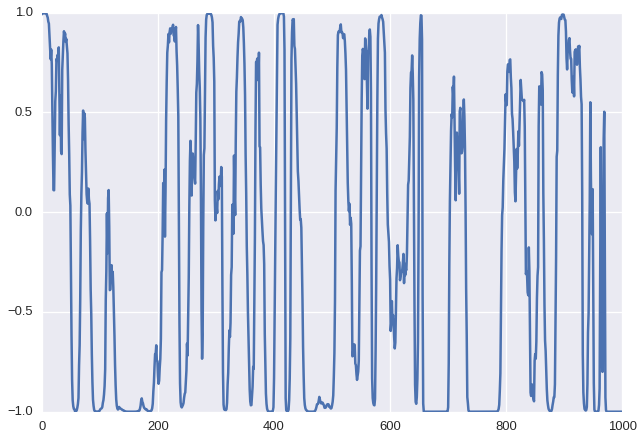

In [204]:
plt.plot(out)
plt.show()

70
{u'start': u'2014/04/28 17:55', u'end': u'2014/04/28 21:16', u'label': []}


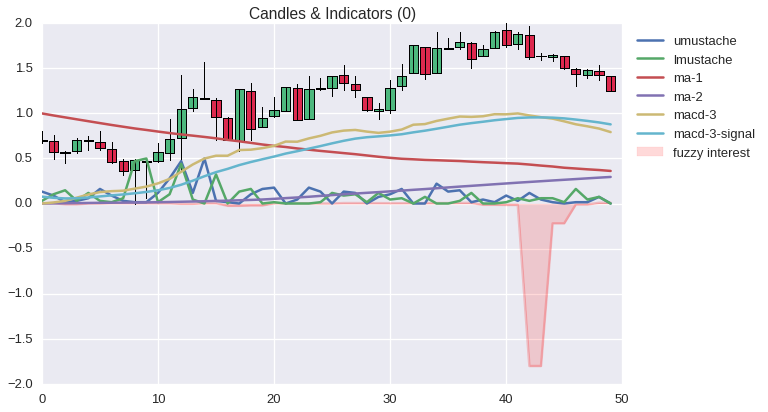

[1] [-0.99073529]
WRONG prediction
-10


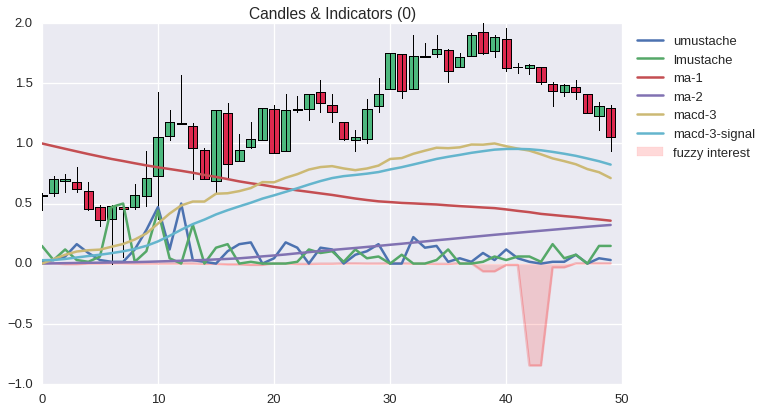

[1] [-0.99553931]
WRONG prediction
-8


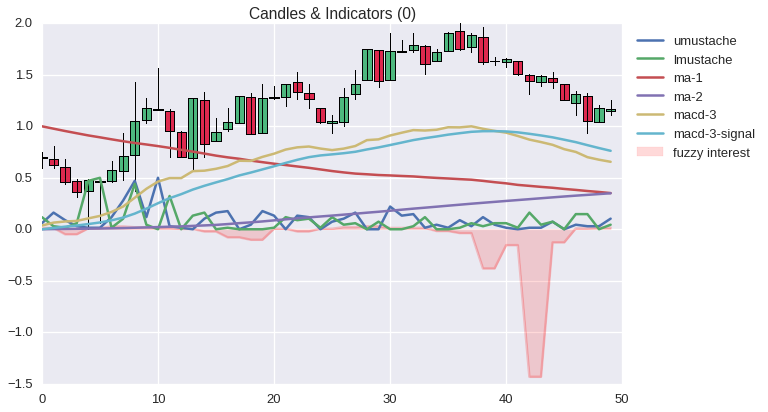

[1] [-0.94960755]
WRONG prediction
-6


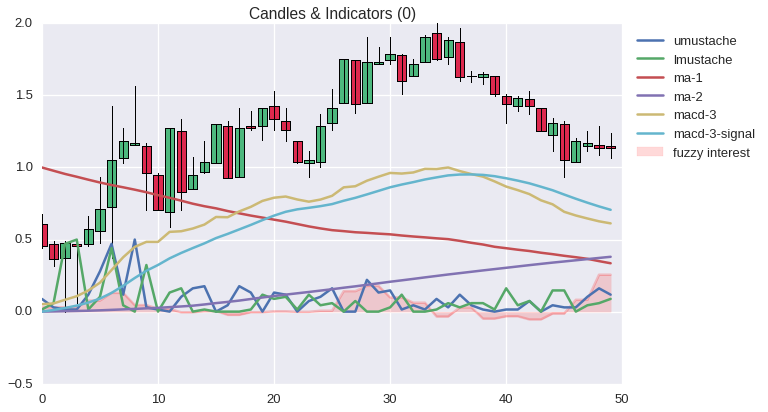

[1] [ 0.94023144]
Ok
-4


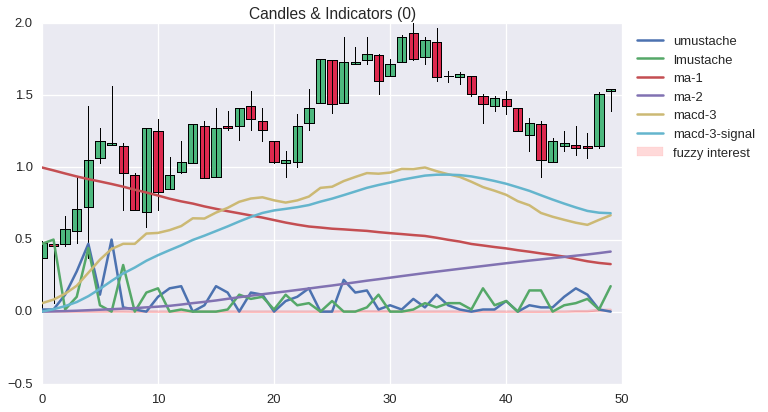

[1] [ 0.99894238]
Ok
-2


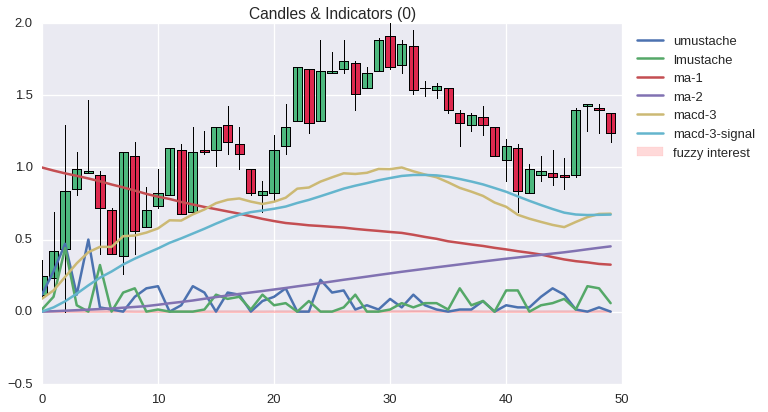

[1] [ 0.99937582]
Ok
0


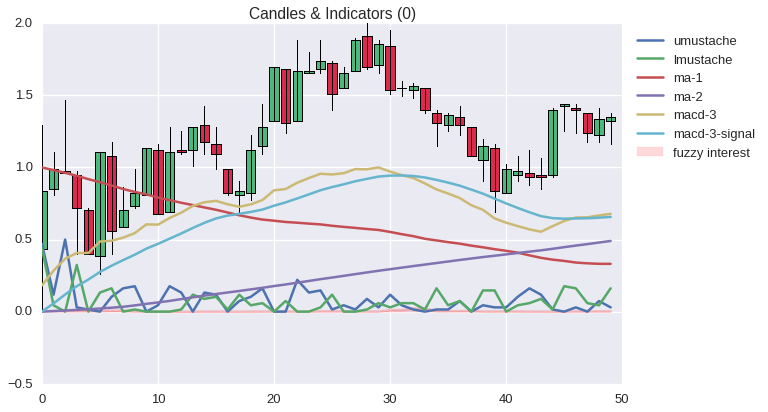

[1] [ 0.99763614]
Ok
2


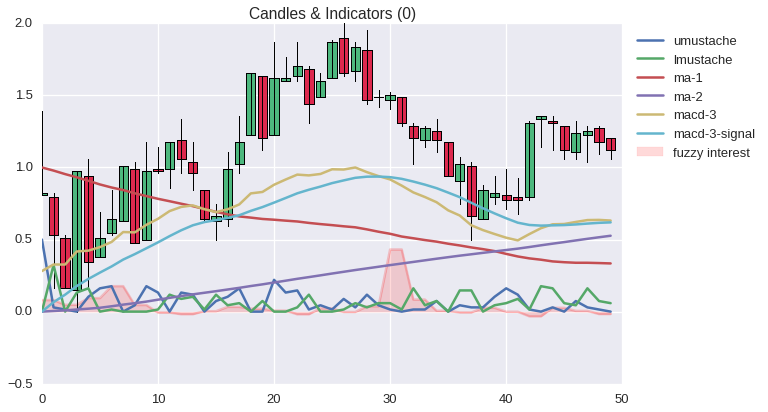

[1] [ 0.93811882]
Ok
4


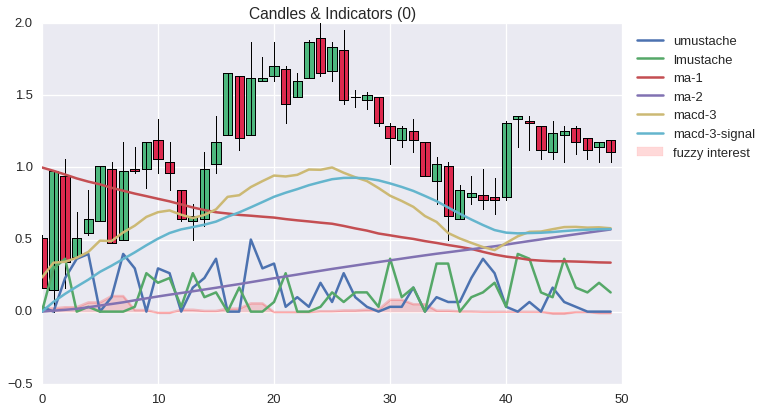

[1] [ 0.96360451]
Ok
6


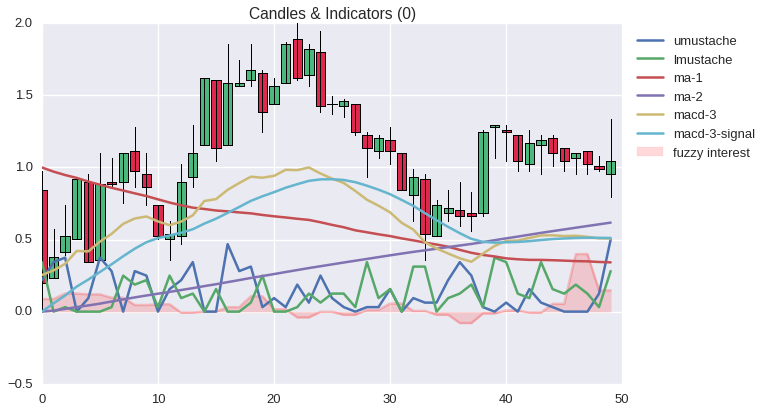

[1] [ 0.88249731]
Ok
8


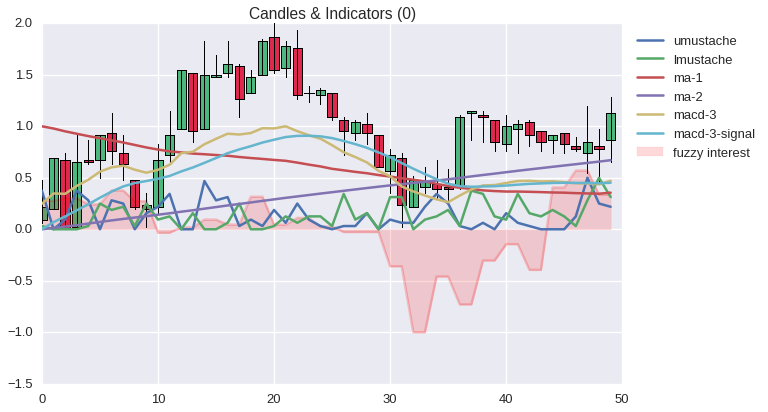

[1] [-0.17782752]
WRONG prediction
10


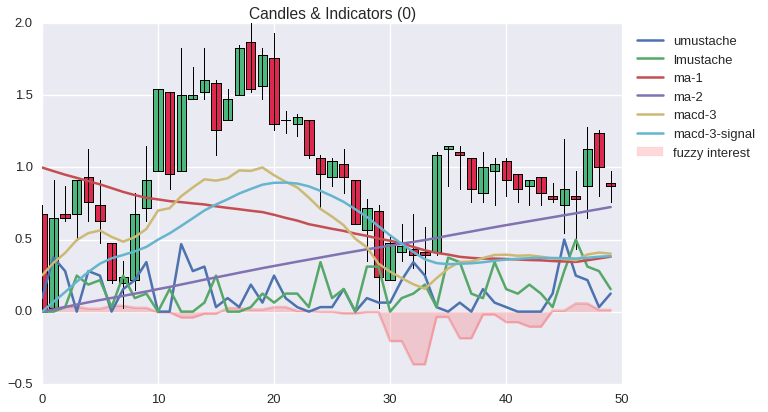

[1] [-0.91642517]
WRONG prediction
12


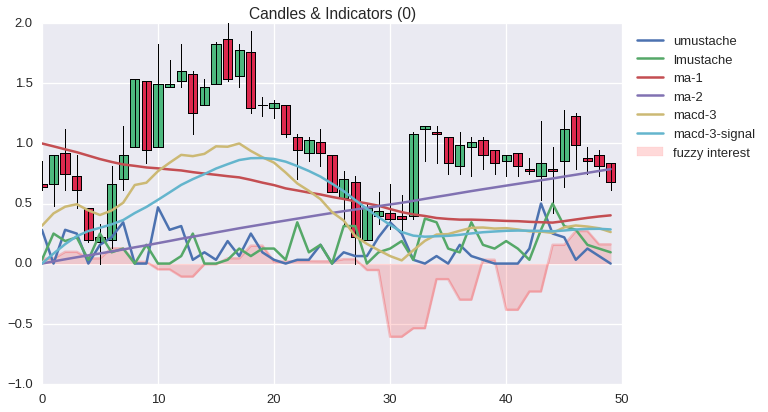

[1] [-0.70290363]
WRONG prediction
14


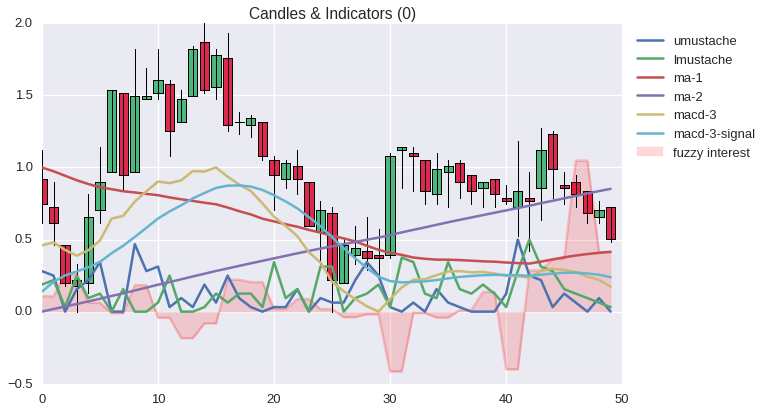

[1] [ 0.19712584]
Ok
16


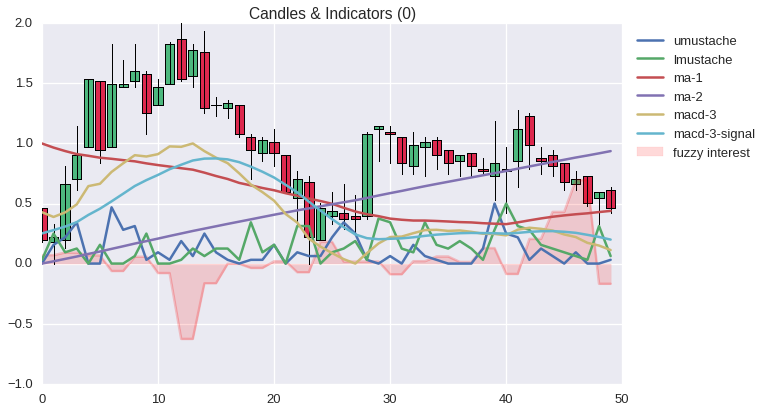

[1] [-0.23998679]
WRONG prediction
18


In [500]:
r = np.random.choice(range(len(dataset)))
print(r)
t = dataset[r]
print(t)
# t = {u's
idx = df.index.get_loc(str(t["end"])[:-1]+str(int(str(t["end"])[-1])-1))
t_start = df.index[idx - 200]

for i in range(-10,20,2):
    
    t_end = df.index[idx + i]
    
    t = {u'start': t_start, u'end': t_end, u'label': []}
    c,_ = select_normalize_from_df(t,
                 df,
                 input_size,
                 justify_right=False)
    plot_ohlc_confidence([[c,[1]]],r=0,mask_size=2)
    print(i)
    # plot_ohlc_ind([c,[-1]],r=0, indicators=indicators)

In [893]:
process_range??

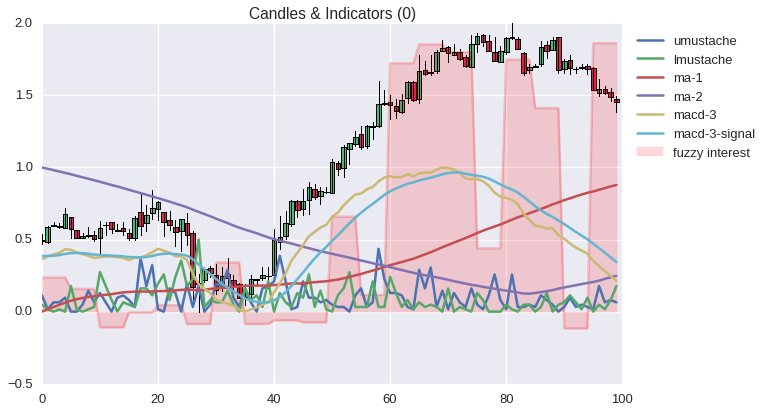

[1] [ 0.88360471]
Ok


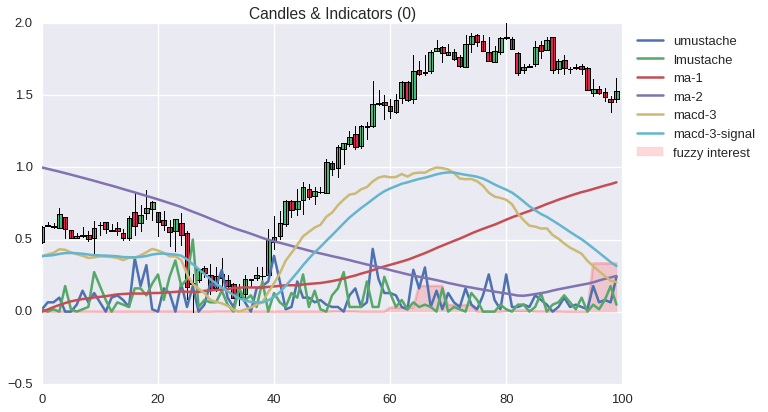

[1] [ 0.99966061]
Ok


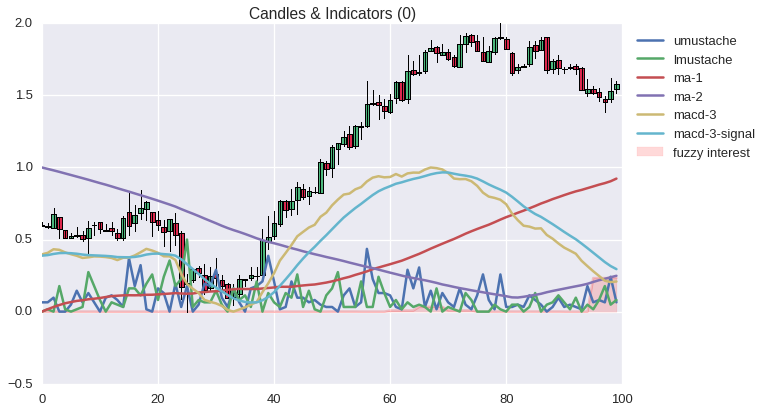

[1] [ 0.99987471]
Ok


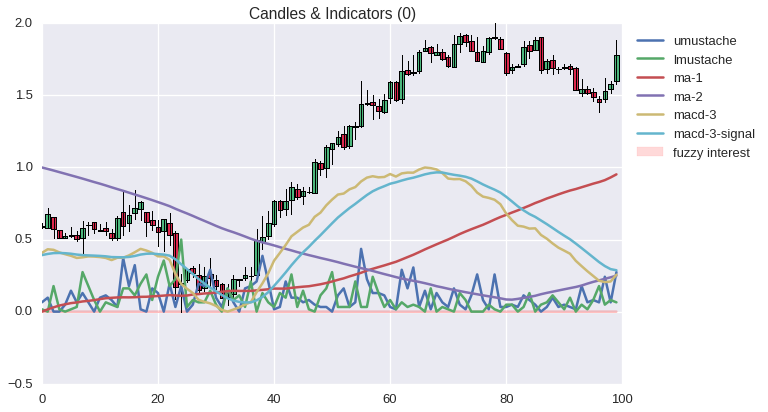

[1] [ 0.99999905]
Ok


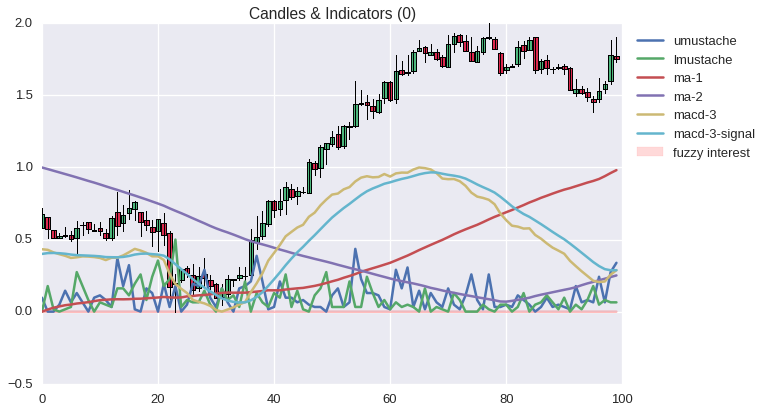

[1] [ 0.99999994]
Ok


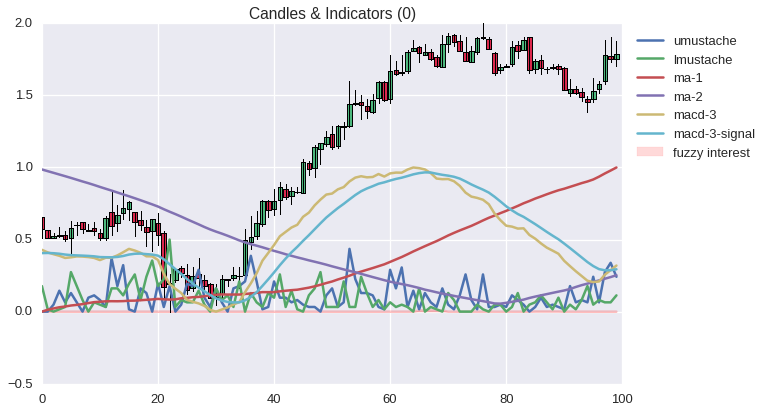

[1] [ 0.99999642]
Ok


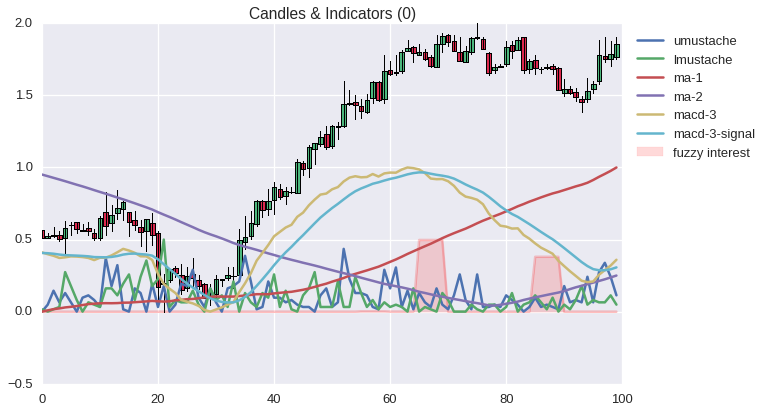

[1] [ 0.99996024]
Ok


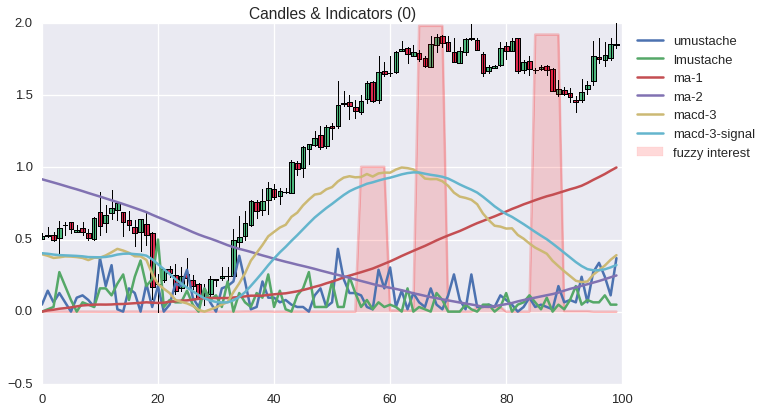

[1] [ 0.99960065]
Ok


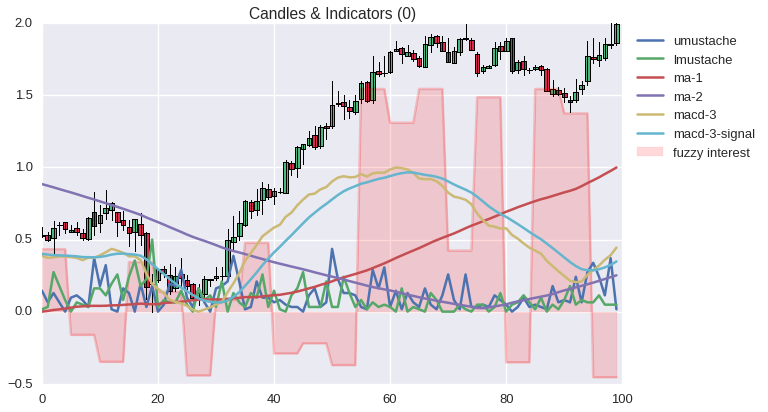

[1] [ 0.54484046]
Ok


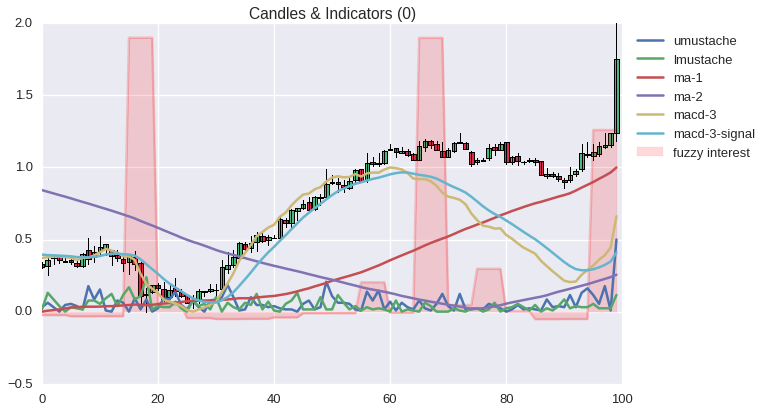

[1] [ 0.94739151]
Ok


In [731]:
idx = df.index.get_loc("2014/02/13 05:50")
t_start = df.index[idx - 200]

for i in range(-5,5,1):
    
    t_end = df.index[idx + i]
    
    t = {u'start': t_start, u'end': t_end, u'label': []}
    c,_ = select_normalize_from_df(t,
                 df,
                 100,
                 justify_right=True)
    plot_ohlc_confidence([[c,[1]]],r=0,mask_size=5)
    # plot_ohlc_ind([c,[-1]],r=0, indicators=indicators)

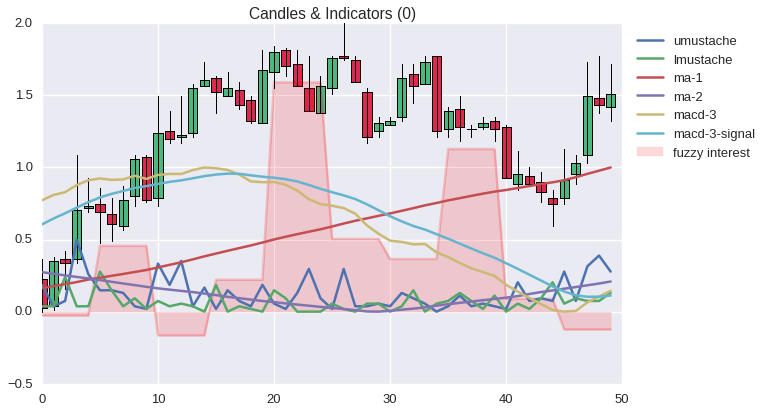

[1] [ 0.80872536]
Ok


In [866]:
c,_ = select_normalize_from_df(t,
             df,
             50,
             justify_right=True)
plot_ohlc_confidence([[c,[1]]],r=0,mask_size=5)
# plot_ohlc_ind([c,[-1]],r=0, indicators=indicators)

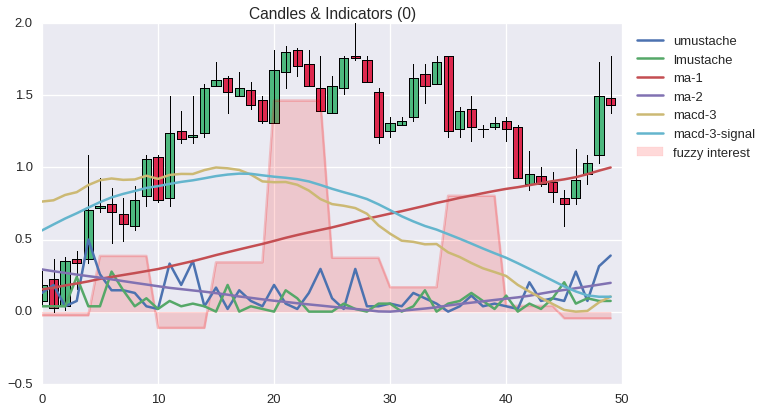

[1] [ 0.86151224]
Ok


In [864]:
c,_ = select_normalize_from_df(t,
             df,
             50,
             justify_right=True)
plot_ohlc_confidence([[c,[1]]],r=0,mask_size=5)
# plot_ohlc_ind([c,[-1]],r=0, indicators=indicators)

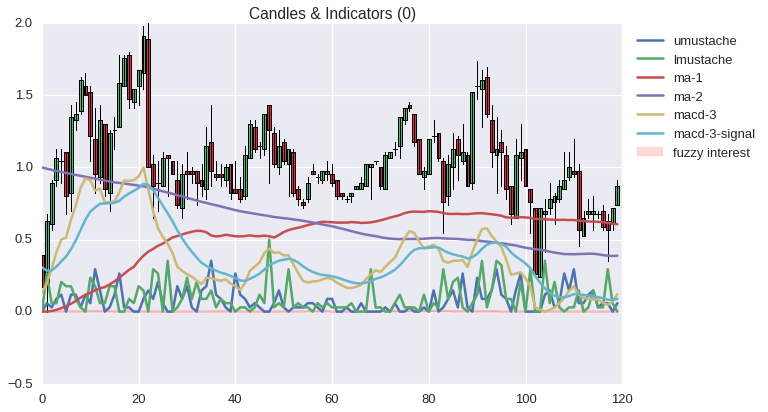

[1] [ 0.99972492]
Ok


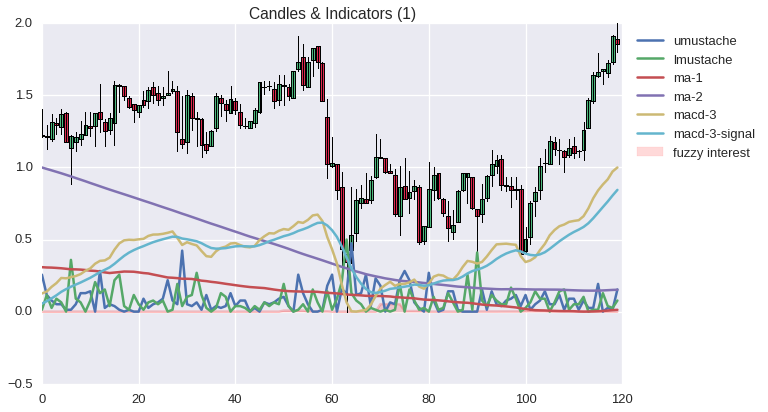

[-1] [ 0.99987608]
WRONG prediction


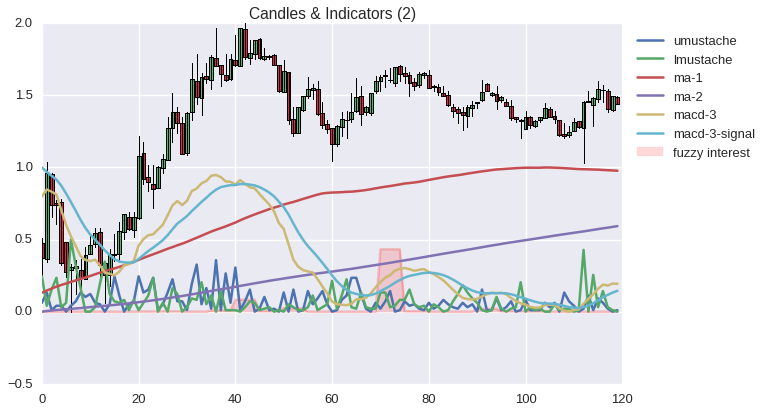

[1] [ 0.99981576]
Ok


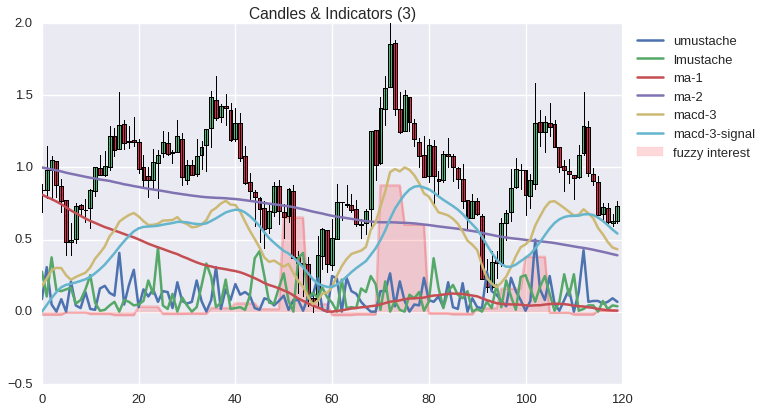

[-1] [ 0.97394264]
WRONG prediction


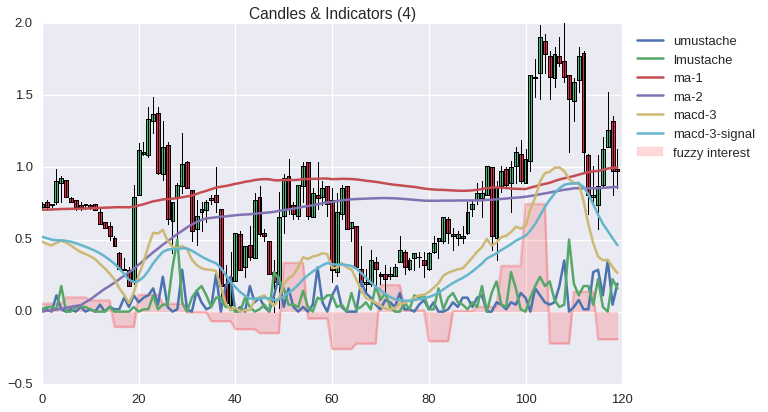

[1] [ 0.73172277]
Ok


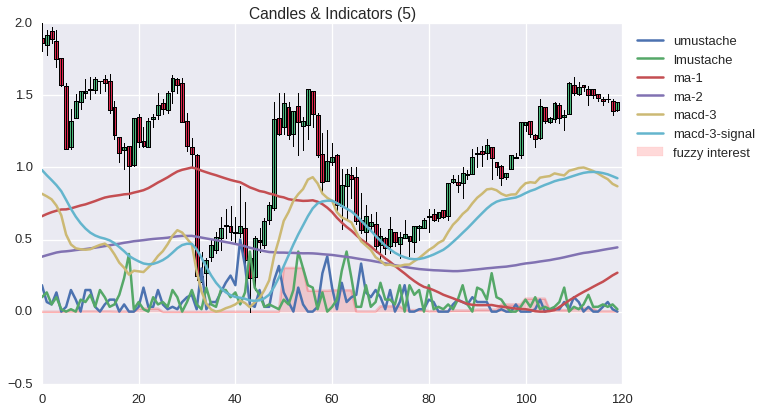

[1] [ 0.99758458]
Ok


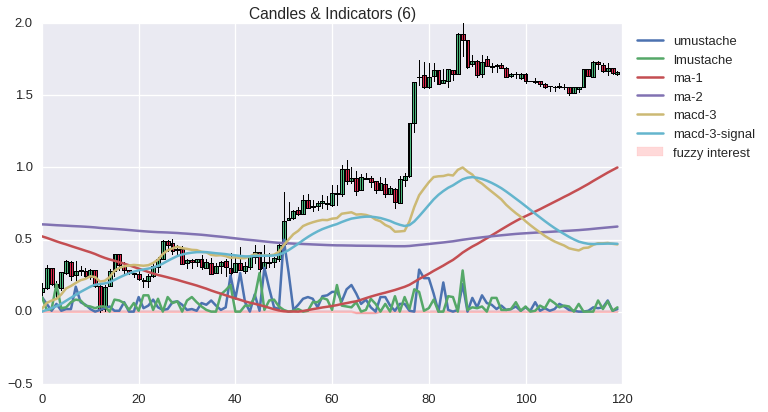

[-1] [-1.]
Ok


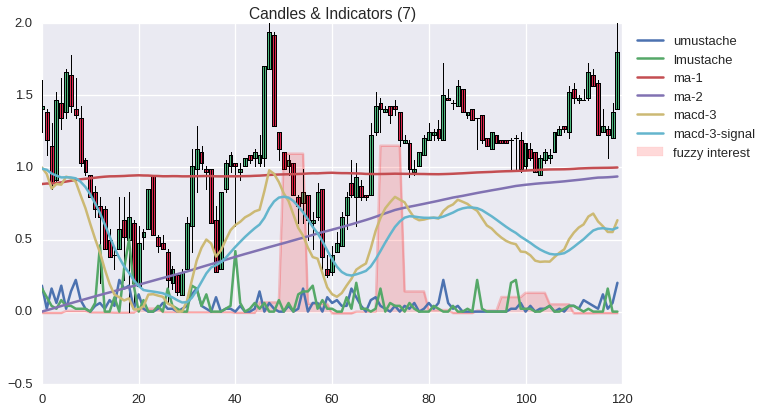

[1] [ 0.98706716]
Ok


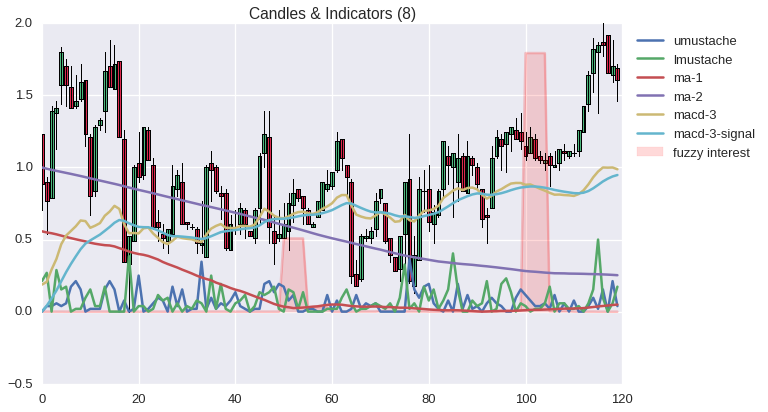

[1] [ 0.99986094]
Ok


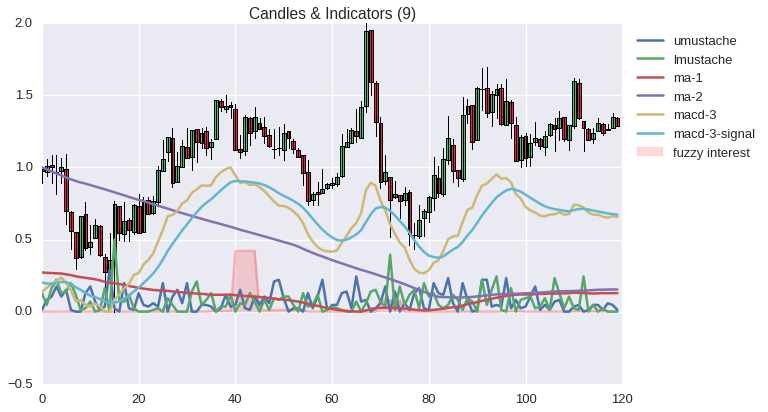

[1] [ 0.99988043]
Ok


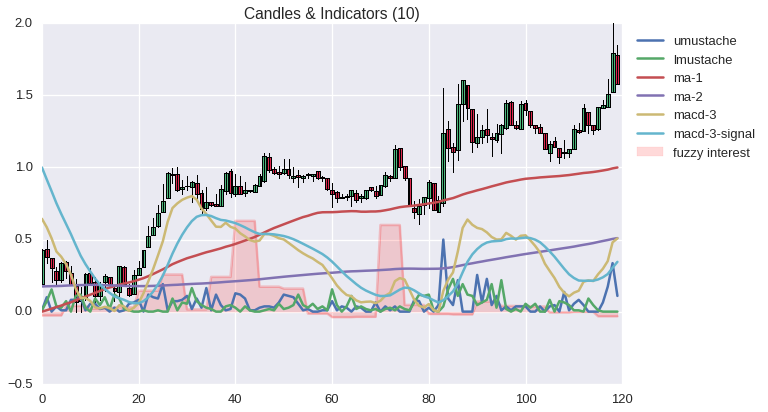

[-1] [ 0.96154153]
WRONG prediction


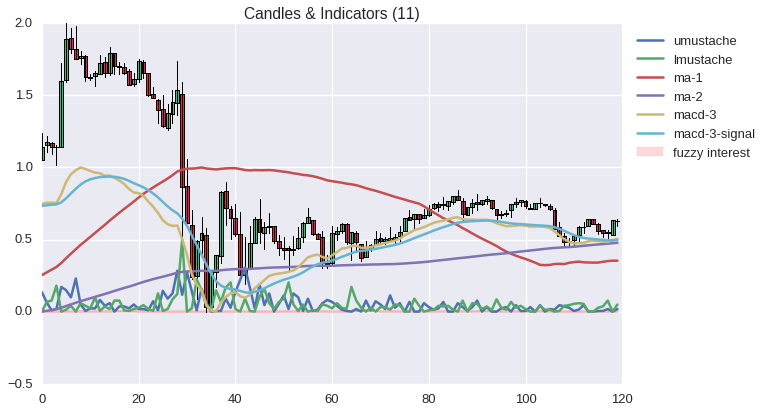

[1] [ 0.99984533]
Ok


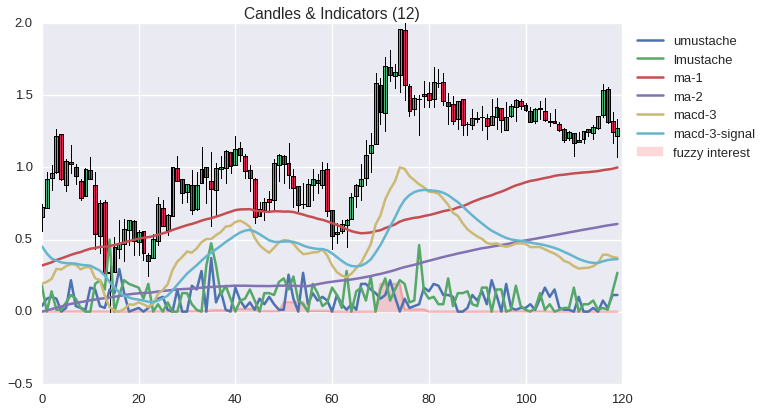

[1] [ 0.99956447]
Ok


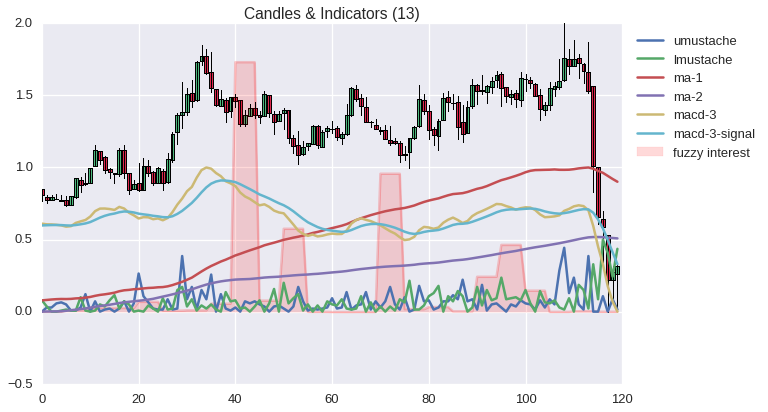

[1] [ 0.99714756]
Ok


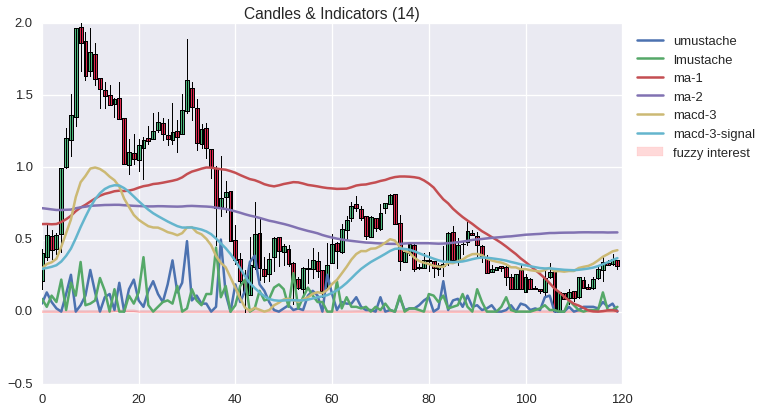

[1] [ 0.99990672]
Ok


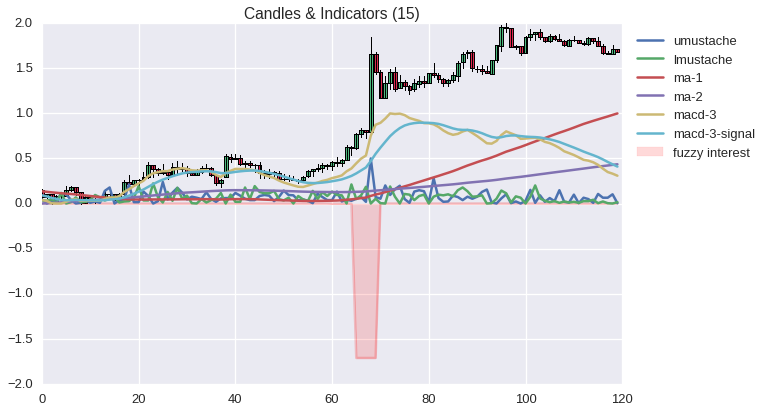

[-1] [-1.]
Ok


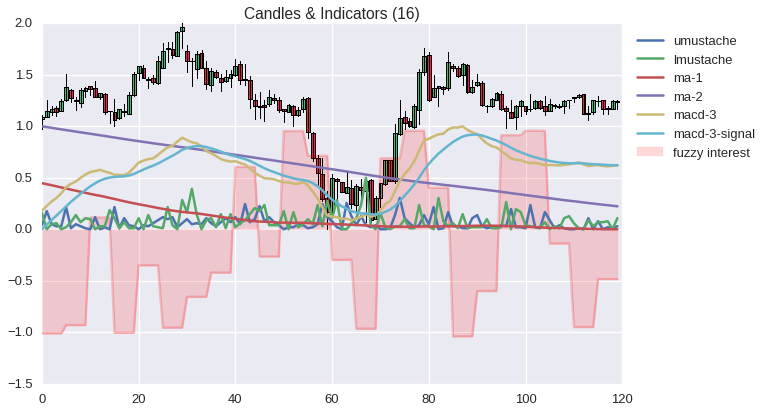

[1] [-0.04298624]
WRONG prediction


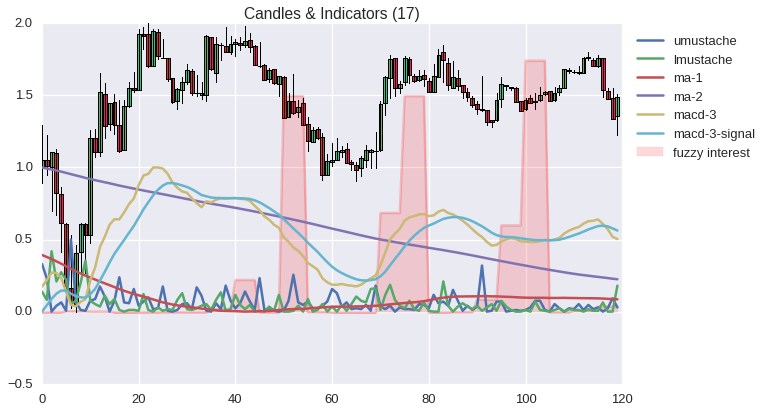

[1] [ 0.99154288]
Ok


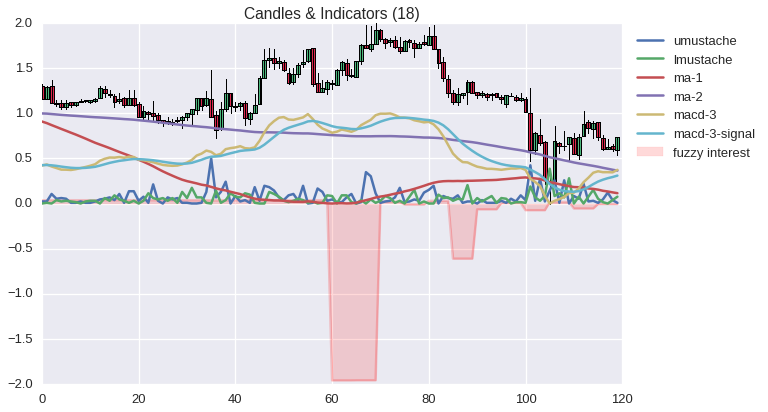

[-1] [-0.96342438]
Ok


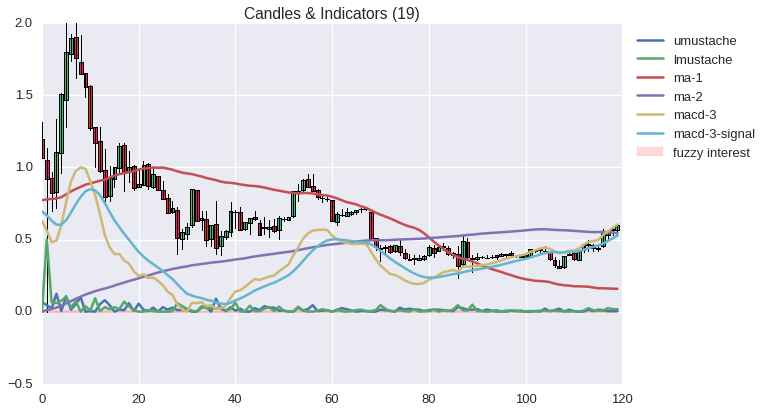

[1] [ 0.99983686]
Ok


In [646]:
for idxi,i in enumerate(test[:20]):
    plot_ohlc_confidence(test,r=idxi,mask_size=5)

In [1023]:
# golden_and_dead_cross/year2014_train.json

---


---


---



---


---


---


---


---

---


---


---



---


---


---


---


---

---


---


---



---


---


---


---


---

---


---


---



---


---


---


---


---